## Import Dependencies

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import  LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import catboost as cb
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics

## Load Data And Preprocess

### Load and Clean

In [43]:
df = pd.read_csv(r'C:\Users\yusuf\Desktop\Workspace url/Trendyol_detailed2.csv')       ## Load the data
df.head(3)

,Unnamed: 0,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Battery Power,Color,Link
0,939,Y21 4gb/64gb,İNOVELSTORE,3399,NaN,4.0,64.0,Android,NaN,NaN,NaN,Mavi,https://www.trendyol.com/vivo/y21-4gb-64gb-p-2...
1,516,Y21 V2111,Çimenli İletişim,3327,NaN,4.0,64.0,Android,NaN,NaN,NaN,Beyaz,https://www.trendyol.com/vivo/y21-v2111-4gb-64...
2,723,1S 2020,Alcatel,2069,1.5-2.0,3.0,32.0,Android,12.5,6.0,3000 - 4000,Gri,https://www.trendyol.com/alcatel/1s-2020-32gb-...


In [44]:
df.drop(columns=['Unnamed: 0','Link','Battery Power'], axis= 1, inplace=True)            ## Drop unused columns
df.head(3)

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
0,Y21 4gb/64gb,İNOVELSTORE,3399,NaN,4.0,64.0,Android,NaN,NaN,Mavi
1,Y21 V2111,Çimenli İletişim,3327,NaN,4.0,64.0,Android,NaN,NaN,Beyaz
2,1S 2020,Alcatel,2069,1.5-2.0,3.0,32.0,Android,12.5,6.0,Gri


In [45]:
df.info()             ## see the null values and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              1176 non-null   object 
 1   Brand              1176 non-null   object 
 2   Price              1176 non-null   int64  
 3   CPU                482 non-null    object 
 4   RAM                1156 non-null   float64
 5   Storage            1147 non-null   float64
 6   Operating System   1166 non-null   object 
 7   Camera Resolution  872 non-null    float64
 8   Screen Size        807 non-null    float64
 9   Color              1118 non-null   object 
dtypes: float64(4), int64(1), object(5)
memory usage: 92.0+ KB


### Fill missing values

There are a lot of missing values but it is easy to fill the missing values by googling the hardware specifications of smartphone models. Same models generally have the same hardware. If possible, this should be considered as a way to impute missing values rather than blindly dropping, or filling the nulls with mean,mode values. It is a version of filling the nulls with mode of the dataset.

In [46]:
## Get indices for the rows of apple iphone 13 models with null cpu column

pp = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('13')==True),'Model'].index

In [47]:
## insert a specific value for the indices defined in the cell above.
df.loc[pp,'CPU'] = 3.2      

In [48]:
## Get indices for the rows of apple iphone S models with null cpu column
rr = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('S')),'Model'].index
## insert a specific value for the indices defined above.
df.loc[rr,'CPU'] = 2.6

In [49]:
## Get indices for the rows of apple iphone 12 models with null cpu column
tt = df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True)&(df.Model.str.contains('12')),'Model'].index
## insert a specific value for the indices defined above.
df.loc[tt,'CPU'] = 3.2
df.loc[tt]

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
92,Iphone 12,Apple,27999,3.2,6.0,128.0,Android,NaN,6.25,Sar
144,Iphone 12,Apple,32599,3.2,3.0,256.0,iOS,50.0,NaN,G
146,İphone 12,Apple,30000,3.2,6.0,128.0,iOS,12.5,6.25,G
179,Iphone 12,Apple,18972,3.2,4.0,64.0,iOS,12.5,6.25,Mor
192,Iphone se 128gb,Apple,11949,3.2,3.0,128.0,iOS,12.5,NaN,K
195,Iphone 12,Apple,22249,3.2,4.0,256.0,iOS,12.5,6.25,Ye


In [50]:
df.loc[(df.Brand=='Apple')& (df.CPU.isna()==True),'CPU'] = 2.8

In [51]:
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)].groupby('Model').count().sort_values('Brand',ascending=False).head()

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Galaxy S22,20,20,0,20,20,20,16,0,20
Galaxy S21,11,11,0,11,11,11,8,1,7
Galaxy Z,11,11,0,11,11,11,2,0,11
Galaxy A13,9,9,0,9,9,9,8,2,9
Galaxy A22,9,9,0,9,9,9,8,0,8


In [52]:
## impute values for specific phone models. the inputs are checked online

df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S22'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S21'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy Z'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A73'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A13'),'CPU'] = 2.2 
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A22'),'CPU'] = 2.2
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S22+'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A12'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A52s'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy Note20'),'CPU'] = 2.6
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A03s'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy J1'),'CPU'] = 1.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A33'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy S20'),'CPU'] = 2.8
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A23'),'CPU'] = 2.4
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A51'),'CPU'] = 2.3
df.loc[(df.Brand=='Samsung')&(df.CPU.isna()==True)&(df.Model=='Galaxy A53'),'CPU'] = 2.4

In [53]:
df.CPU.replace(['0.5-1.0','1.5-2.0','1.0-1.5','2.5-3.2', '2.0-2.5'],[0.8,1.8,1.3,2.8,2.3],inplace=True)

In [54]:
df.loc[df['Camera Resolution'].isna()==True].groupby('Model').count().sort_values('Brand',ascending=False)

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Redmi Note,40,40,6,39,39,40,0,19,37
P13 Blue,13,13,0,12,13,13,0,6,13
Iphone 13,13,13,13,13,13,13,0,10,8
Galaxy Z,9,9,9,9,9,9,0,0,9
Gm 22,8,8,0,8,8,8,0,0,8
...,...,...,...,...,...,...,...,...,...
Hiking A27,1,1,0,1,1,1,0,0,1
Gt Master,1,1,0,1,1,1,0,1,1
Galaxy S22+,1,1,1,1,1,1,0,1,1


In [55]:
tt=df[df.Model=='Redmi Note'].index                ## get the index numbers of the this model

In [56]:
df.loc[tt,'CPU'] = 2.3                              ## change the CPU values of this model. 

In [57]:
df.loc[(df.Model=='P13 Blue')&(df.CPU.isna()==True),'CPU']=2.4                

In [58]:
df.loc[(df.Model=='Redmi Note')&(df['Camera Resolution'].isna()==True),'Camera Resolution'] = 48

In [59]:
df.loc[(df.Model=='Iphone 13')&(df['Camera Resolution'].isna()==True),'Camera Resolution'] = 12

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              1176 non-null   object 
 1   Brand              1176 non-null   object 
 2   Price              1176 non-null   int64  
 3   CPU                812 non-null    float64
 4   RAM                1156 non-null   float64
 5   Storage            1147 non-null   float64
 6   Operating System   1166 non-null   object 
 7   Camera Resolution  925 non-null    float64
 8   Screen Size        807 non-null    float64
 9   Color              1118 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 92.0+ KB


In [61]:
df[df['Screen Size'].isna()==True].groupby('Model').count().sort_values('CPU',ascending=False).head()

,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
Model,,,,,,,,,
Redmi Note,30,30,30,30,30,30,30,0,28
Galaxy S22,20,20,20,20,20,20,16,0,20
Galaxy Z,11,11,11,11,11,11,2,0,11
P13 Blue,11,11,11,11,11,11,4,0,11
Galaxy S21,10,10,10,10,10,10,8,0,6


In [62]:
## impute values for specific phone models. the inputs are checked online

df.loc[(df.Model=='Redmi Note')&(df['Screen Size'].isna()==True),'Screen Size'] = 6
df.loc[(df.Model=='Galaxy S22')&(df['Screen Size'].isna()==True),'Screen Size'] = 6
df.loc[(df.Model=='Galaxy S21')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.2
df.loc[(df.Model=='Galaxy Z')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.7
df.loc[(df.Model=='P13 Blue')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.2
df.loc[(df.Model=='iPhone SE')&(df['Screen Size'].isna()==True),'Screen Size'] = 4.7
df.loc[(df.Model=='Galaxy A73')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.7
df.loc[(df.Model=='Galaxy A22')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.4
df.loc[(df.Model=='Galaxy S22+')&(df['Screen Size'].isna()==True),'Screen Size'] = 6.6

In [63]:
brands=df.groupby('Brand').count().sort_values('Model',ascending=False).index[:10]    ## get the names of the top 10 brands

In [64]:
df1 =df.loc[df.Brand.isin(brands)==True]                          ## Create a data frame with only the top 10 brands
df1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 12 to 1160
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Model              936 non-null    object 
 1   Brand              936 non-null    object 
 2   Price              936 non-null    int64  
 3   CPU                727 non-null    float64
 4   RAM                934 non-null    float64
 5   Storage            928 non-null    float64
 6   Operating System   934 non-null    object 
 7   Camera Resolution  744 non-null    float64
 8   Screen Size        772 non-null    float64
 9   Color              883 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 80.4+ KB


In [65]:
## convert Turkish words into English 
ders = {'Siyah':'Black','Mavi':'Blue','Beyaz':'White','Ye':'Green','Gri':'Gray','Mor':'Purple','K':'Red',
                  'Alt':'Golden','Pembe':'Pink','Sar':'Yellow','Turuncu':'Orange','Metalik':'Metallic','Lacivert':'Blue',
                  'Turkuaz':'Turquoise','Bej':'Cream','Bordo':'Red','Kahverengi':'Brown'}


In [66]:
a= pd.json_normalize(ders).columns
b = pd.json_normalize(ders).T.iloc[:,0].values
b

array(['Black', 'Blue', 'White', 'Green', 'Gray', 'Purple', 'Red',
       'Golden', 'Pink', 'Yellow', 'Orange', 'Metallic', 'Blue',
       'Turquoise', 'Cream', 'Red', 'Brown'], dtype=object)

In [67]:
df.replace(a,b,inplace=True)              ## replace the Turkish values with the English ones.

In [68]:
df.groupby('Color').count().sort_values('Model',ascending=False).head(5)    ## get the color numbers and sort descending

,Model,Brand,Price,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
Color,,,,,,,,,
Black,270,270,270,172,261,260,268,203,201
Blue,266,266,266,172,265,265,266,217,204
White,157,157,157,119,154,148,153,130,126
Green,119,119,119,93,118,118,119,92,102
Gray,114,114,114,85,113,111,112,95,97


In [81]:
df1.drop(columns='Price').head(100)

,Model,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size,Color
12,iPhone 13,Apple,3.2,6.0,128.0,iOS,7.5,6.25,Red
13,iPhone SE,Apple,1.8,2.0,64.0,iOS,12.5,4.00,Black
14,iPhone 11,Apple,2.8,4.0,128.0,iOS,12.5,6.00,Black
15,iPhone 11,Apple,2.8,4.0,64.0,iOS,12.5,6.00,Purple
16,iPhone 11,Apple,2.8,4.0,128.0,iOS,12.5,6.00,White
...,...,...,...,...,...,...,...,...,...
107,iPhone 13,Apple,3.2,6.0,512.0,iOS,7.5,6.25,Black
108,iPhone 13,Apple,3.2,6.0,512.0,iOS,7.5,6.25,Pink
109,iPhone 13,Apple,3.2,4.0,512.0,iOS,12.5,6.25,Green
110,iPhone 12,Apple,2.8,6.0,512.0,iOS,12.5,6.00,Golden


In [82]:
## Standardize the model names, different capitalization and misspelings make the data look bad.
df.loc[(df.Model.str.contains('13')==True)&(df.Brand=='Apple'),'Model']='iPhone 13'  

In [83]:
df1 =df.loc[df.Brand.isin(brands)==True]     

In [84]:
# df1.to_csv('smartphone_colors.csv')      ## save the dataframe before dropping the color column
df1 = df1.drop(columns='Color')                   ##  Drop the color column
   

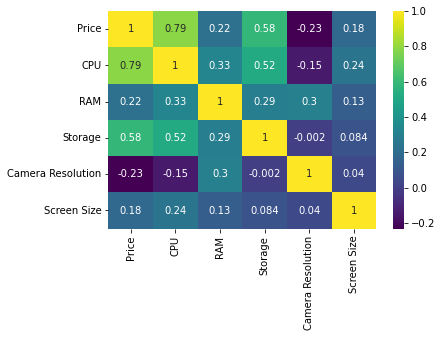

In [85]:
cor = df1.corr()                                  ## correlation martix
sns.heatmap(cor,annot= True , cmap = 'viridis' ) 
plt.show()

In [35]:
df1.dropna(inplace=True)             ## drop the null values that are not filled by now.

### Select Features and Split the Data

I drop 'Model' and 'Color' column because I do not think these are not as effective as other features on price

In [36]:
x= df1.drop(columns = ['Price','Model'])             ## split the features and the label 
x

,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
12,Apple,3.2,6.0,128.0,iOS,7.5,6.25
13,Apple,1.8,2.0,64.0,iOS,12.5,4.00
14,Apple,2.8,4.0,128.0,iOS,12.5,6.00
15,Apple,2.8,4.0,64.0,iOS,12.5,6.00
16,Apple,2.8,4.0,128.0,iOS,12.5,6.00
...,...,...,...,...,...,...,...
1154,Xiaomi,2.3,2.0,32.0,Android,12.5,6.00
1155,Xiaomi,2.3,3.0,64.0,Android,12.5,6.00
1156,Xiaomi,2.3,4.0,128.0,Android,50.0,6.25
1159,Xiaomi,2.3,4.0,128.0,Android,20.0,6.00


In [37]:
le = LabelEncoder()                               ## call label encoder to convert the categorical data into numerical data
x1 = le.fit_transform(x.Brand.values)              ## convert the brand column
x2 = le.fit_transform(x['Operating System'].values)     ## conver the OS column

In [38]:
x.Brand = x1                              ## replace the columns with new format
x['Operating System']  = x2    
x

,Brand,CPU,RAM,Storage,Operating System,Camera Resolution,Screen Size
12,0,3.2,6.0,128.0,1,7.5,6.25
13,0,1.8,2.0,64.0,1,12.5,4.00
14,0,2.8,4.0,128.0,1,12.5,6.00
15,0,2.8,4.0,64.0,1,12.5,6.00
16,0,2.8,4.0,128.0,1,12.5,6.00
...,...,...,...,...,...,...,...
1154,8,2.3,2.0,32.0,0,12.5,6.00
1155,8,2.3,3.0,64.0,0,12.5,6.00
1156,8,2.3,4.0,128.0,0,50.0,6.25
1159,8,2.3,4.0,128.0,0,20.0,6.00


In [39]:
y = df1.Price   ## define target column

In [40]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)  ## split the data into test and train

### Modelling

In [41]:
model = xgb.XGBRegressor()       ##call the model

In [42]:
params = {'max_depth' : [15,20,25],              ## define parameter values for tuning.
         'learning_rate':[0.3,0.5,0.7],
         'n_estimators':[300,400,500],
          'min_child_weight':[6,8,10]
         }

In [43]:
grid = GridSearchCV(model,param_grid=params,verbose=2,cv=3)    ## input the components and create a gridsearchcv module.

In [44]:
grid.fit(x_train,y_train)             ## fit the data

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.6s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=15, min_c

[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.2s
[CV] END l

[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=400; total time=   0.3s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=6, n_estimators=500; total time=   0.4s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=8, n_estimators=300; total time=   0.2s
[CV] END learning_rate=0.7, max_depth=15, min_child_weight=8, n_estimators=400; total time=   0.3s
[CV] END l

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.3, 0.5, 0.7],
                         'max_depth': [15, 20, 25],
                         'min_child_weight': [6, 8, 10],
                         'n_estimators': [300, 400, 500]},
             verbose=2)

In [45]:
grid.best_estimator_                   ## the gridsearchcv returns the best parameters values.

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [46]:
## pass in the best parameter values.
model_xgb=xgb.XGBRegressor(max_depth=15,min_child_weight=8,n_estimators=500,learning_rate=0.5)    

In [47]:
##  train the data with the tuned parameters.
model_1=model_xgb.fit(x_train,y_train)  

In [48]:
## make predictions

y_pred1=model_1.predict(x_test)

### Evaluation

In [49]:
## measure the performance for different metrics.

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))
print('R2 score:', metrics.r2_score(y_pred1,y_test))

Mean Absolute Error: 1163.7010962115833
Mean Squared Error: 4535339.210361445
Root Mean Squared Error: 2129.6335859394794
R2 score: 0.953404811728709


In [50]:
## call another model

model1=cb.CatBoostRegressor()

In [51]:
## define parameter values and apply them in a grid module

params1 = {'max_depth':[6,10,15],
          'iterations':[120,150,200],
          'learning_rate':[0.1,0.2,0.3]}

grid1=GridSearchCV(model1,param_grid=params1,verbose=2,cv=3)

In [52]:
grid1.fit(x_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
0:	learn: 9165.3873746	total: 164ms	remaining: 19.5s
1:	learn: 8505.5320813	total: 164ms	remaining: 9.7s
2:	learn: 8043.7295726	total: 165ms	remaining: 6.43s
3:	learn: 7502.6391241	total: 165ms	remaining: 4.79s
4:	learn: 7052.1104238	total: 166ms	remaining: 3.81s
5:	learn: 6669.3018374	total: 166ms	remaining: 3.16s
6:	learn: 6221.0531058	total: 167ms	remaining: 2.69s
7:	learn: 5892.2487615	total: 168ms	remaining: 2.35s
8:	learn: 5591.3680781	total: 168ms	remaining: 2.08s
9:	learn: 5300.8812774	total: 169ms	remaining: 1.86s
10:	learn: 5037.3502087	total: 170ms	remaining: 1.68s
11:	learn: 4830.5901384	total: 170ms	remaining: 1.53s
12:	learn: 4622.4315727	total: 170ms	remaining: 1.4s
13:	learn: 4425.6450100	total: 171ms	remaining: 1.29s
14:	learn: 4245.6034080	total: 172ms	remaining: 1.2s
15:	learn: 4108.9463467	total: 172ms	remaining: 1.12s
16:	learn: 3971.4271923	total: 172ms	remaining: 1.04s
17:	learn: 3838.4107966	total: 173

76:	learn: 1597.1702203	total: 47.8ms	remaining: 26.7ms
77:	learn: 1584.4716505	total: 48.7ms	remaining: 26.2ms
78:	learn: 1580.1474969	total: 49.3ms	remaining: 25.6ms
79:	learn: 1570.0365436	total: 50.1ms	remaining: 25.1ms
80:	learn: 1568.2316134	total: 50.6ms	remaining: 24.4ms
81:	learn: 1567.5327774	total: 51.1ms	remaining: 23.7ms
82:	learn: 1561.4568003	total: 51.7ms	remaining: 23ms
83:	learn: 1555.8459966	total: 52.3ms	remaining: 22.4ms
84:	learn: 1546.7026609	total: 52.8ms	remaining: 21.8ms
85:	learn: 1540.9723926	total: 53.4ms	remaining: 21.1ms
86:	learn: 1530.8725692	total: 54ms	remaining: 20.5ms
87:	learn: 1521.9657537	total: 54.5ms	remaining: 19.8ms
88:	learn: 1515.6994247	total: 55.1ms	remaining: 19.2ms
89:	learn: 1509.4689396	total: 55.7ms	remaining: 18.6ms
90:	learn: 1502.0447282	total: 56.3ms	remaining: 17.9ms
91:	learn: 1493.4545013	total: 56.9ms	remaining: 17.3ms
92:	learn: 1484.9310730	total: 57.6ms	remaining: 16.7ms
93:	learn: 1482.2173285	total: 58.4ms	remaining: 16.

11:	learn: 4635.8554416	total: 11.2ms	remaining: 101ms
12:	learn: 4415.4774047	total: 11.9ms	remaining: 98.3ms
13:	learn: 4225.6517151	total: 13.8ms	remaining: 105ms
14:	learn: 4029.6083374	total: 15.4ms	remaining: 108ms
15:	learn: 3866.5348566	total: 16.2ms	remaining: 105ms
16:	learn: 3717.6343476	total: 17.2ms	remaining: 104ms
17:	learn: 3604.2820690	total: 17.7ms	remaining: 100ms
18:	learn: 3472.8263994	total: 18.5ms	remaining: 98.3ms
19:	learn: 3338.1136191	total: 20.2ms	remaining: 101ms
20:	learn: 3244.6659944	total: 20.9ms	remaining: 98.5ms
21:	learn: 3155.5051557	total: 22.3ms	remaining: 99.5ms
22:	learn: 3069.0995346	total: 23.9ms	remaining: 101ms
23:	learn: 2981.3194392	total: 24.7ms	remaining: 99ms
24:	learn: 2920.2786024	total: 25.3ms	remaining: 96.2ms
25:	learn: 2836.2903112	total: 27ms	remaining: 97.6ms
26:	learn: 2762.3133121	total: 27.7ms	remaining: 95.5ms
27:	learn: 2722.8095598	total: 28.1ms	remaining: 92.4ms
28:	learn: 2667.4534193	total: 29ms	remaining: 91ms
29:	lear

87:	learn: 1215.2758458	total: 153ms	remaining: 55.7ms
88:	learn: 1207.5421020	total: 155ms	remaining: 54.1ms
89:	learn: 1202.7268235	total: 157ms	remaining: 52.4ms
90:	learn: 1195.5450343	total: 159ms	remaining: 50.6ms
91:	learn: 1190.4539076	total: 161ms	remaining: 48.9ms
92:	learn: 1185.3684259	total: 163ms	remaining: 47.2ms
93:	learn: 1179.5700236	total: 165ms	remaining: 45.6ms
94:	learn: 1174.9251027	total: 167ms	remaining: 43.9ms
95:	learn: 1170.6643268	total: 169ms	remaining: 42.2ms
96:	learn: 1165.7829455	total: 171ms	remaining: 40.5ms
97:	learn: 1162.7111588	total: 172ms	remaining: 38.7ms
98:	learn: 1159.0413738	total: 174ms	remaining: 36.9ms
99:	learn: 1153.9014631	total: 176ms	remaining: 35.1ms
100:	learn: 1149.1384409	total: 177ms	remaining: 33.3ms
101:	learn: 1147.0468770	total: 179ms	remaining: 31.6ms
102:	learn: 1143.8448210	total: 182ms	remaining: 30ms
103:	learn: 1140.3574696	total: 184ms	remaining: 28.3ms
104:	learn: 1137.6713887	total: 186ms	remaining: 26.5ms
105:	le

[CV] END ....iterations=120, learning_rate=0.1, max_depth=10; total time=   0.2s
0:	learn: 9174.6114753	total: 766us	remaining: 91.2ms
1:	learn: 8587.8835882	total: 2.45ms	remaining: 145ms
2:	learn: 8010.5862273	total: 3.22ms	remaining: 126ms
3:	learn: 7480.1163365	total: 3.73ms	remaining: 108ms
4:	learn: 7006.4556673	total: 4.95ms	remaining: 114ms
5:	learn: 6541.3915787	total: 5.93ms	remaining: 113ms
6:	learn: 6178.2603811	total: 6.44ms	remaining: 104ms
7:	learn: 5829.2750907	total: 7.02ms	remaining: 98.2ms
8:	learn: 5499.5479188	total: 7.51ms	remaining: 92.6ms
9:	learn: 5167.4294793	total: 8.07ms	remaining: 88.7ms
10:	learn: 4876.3179449	total: 13.3ms	remaining: 132ms
11:	learn: 4633.1535945	total: 14.1ms	remaining: 127ms
12:	learn: 4416.0101325	total: 14.6ms	remaining: 120ms
13:	learn: 4227.5640472	total: 17.1ms	remaining: 130ms
14:	learn: 4029.7915662	total: 19.5ms	remaining: 136ms
15:	learn: 3866.5776247	total: 37.4ms	remaining: 243ms
16:	learn: 3703.3997736	total: 46ms	remaining:

40:	learn: 1862.7768093	total: 171ms	remaining: 329ms
41:	learn: 1818.7344865	total: 180ms	remaining: 334ms
42:	learn: 1798.4112132	total: 184ms	remaining: 329ms
43:	learn: 1778.0706151	total: 185ms	remaining: 320ms
44:	learn: 1737.2075295	total: 219ms	remaining: 365ms
45:	learn: 1716.7521469	total: 220ms	remaining: 354ms
46:	learn: 1685.3368654	total: 233ms	remaining: 362ms
47:	learn: 1653.4356516	total: 255ms	remaining: 382ms
48:	learn: 1634.1197505	total: 257ms	remaining: 372ms
49:	learn: 1625.4203938	total: 257ms	remaining: 360ms
50:	learn: 1614.0322917	total: 259ms	remaining: 350ms
51:	learn: 1605.5048928	total: 260ms	remaining: 340ms
52:	learn: 1579.5459458	total: 262ms	remaining: 331ms
53:	learn: 1552.7512666	total: 303ms	remaining: 370ms
54:	learn: 1523.7993382	total: 309ms	remaining: 365ms
55:	learn: 1492.5523467	total: 351ms	remaining: 402ms
56:	learn: 1476.4461256	total: 363ms	remaining: 402ms
57:	learn: 1471.8557765	total: 364ms	remaining: 389ms
58:	learn: 1446.1206081	tota

70:	learn: 1454.6393297	total: 611ms	remaining: 421ms
71:	learn: 1443.2068676	total: 635ms	remaining: 424ms
72:	learn: 1432.5102276	total: 678ms	remaining: 437ms
73:	learn: 1419.8103634	total: 717ms	remaining: 446ms
74:	learn: 1412.5989396	total: 719ms	remaining: 432ms
75:	learn: 1402.5315805	total: 765ms	remaining: 443ms
76:	learn: 1391.9073784	total: 812ms	remaining: 454ms
77:	learn: 1390.5854898	total: 813ms	remaining: 438ms
78:	learn: 1383.6139300	total: 817ms	remaining: 424ms
79:	learn: 1372.8568649	total: 863ms	remaining: 431ms
80:	learn: 1362.4127911	total: 909ms	remaining: 438ms
81:	learn: 1352.0103751	total: 953ms	remaining: 442ms
82:	learn: 1341.7507053	total: 1s	remaining: 446ms
83:	learn: 1333.6558921	total: 1.05s	remaining: 450ms
84:	learn: 1326.0166856	total: 1.09s	remaining: 449ms
85:	learn: 1319.4038339	total: 1.14s	remaining: 450ms
86:	learn: 1313.4788110	total: 1.18s	remaining: 447ms
87:	learn: 1306.0390408	total: 1.22s	remaining: 444ms
88:	learn: 1299.1072599	total: 

30:	learn: 1779.1413610	total: 16.8ms	remaining: 48.3ms
31:	learn: 1753.0423661	total: 17.8ms	remaining: 49ms
32:	learn: 1735.9503989	total: 19.1ms	remaining: 50.3ms
33:	learn: 1723.8228565	total: 19.9ms	remaining: 50.2ms
34:	learn: 1692.4592737	total: 20.7ms	remaining: 50.2ms
35:	learn: 1678.2944914	total: 21.3ms	remaining: 49.6ms
36:	learn: 1646.0461187	total: 21.8ms	remaining: 48.9ms
37:	learn: 1628.2447496	total: 22.3ms	remaining: 48.2ms
38:	learn: 1600.8969774	total: 22.8ms	remaining: 47.5ms
39:	learn: 1587.6634732	total: 23.4ms	remaining: 46.9ms
40:	learn: 1566.1758098	total: 24ms	remaining: 46.2ms
41:	learn: 1550.0731669	total: 24.5ms	remaining: 45.5ms
42:	learn: 1528.3423754	total: 25ms	remaining: 44.8ms
43:	learn: 1510.9602983	total: 25.6ms	remaining: 44.1ms
44:	learn: 1498.2557063	total: 26.1ms	remaining: 43.5ms
45:	learn: 1489.7415394	total: 26.7ms	remaining: 42.9ms
46:	learn: 1480.6019162	total: 27.3ms	remaining: 42.3ms
47:	learn: 1470.4989941	total: 28ms	remaining: 41.9ms


114:	learn: 1277.4639461	total: 65.6ms	remaining: 2.85ms
115:	learn: 1275.1211510	total: 66.4ms	remaining: 2.29ms
116:	learn: 1271.9253005	total: 67.6ms	remaining: 1.73ms
117:	learn: 1271.5075617	total: 68.5ms	remaining: 1.16ms
118:	learn: 1269.5551730	total: 69.3ms	remaining: 582us
119:	learn: 1268.0636822	total: 70ms	remaining: 0us
[CV] END .....iterations=120, learning_rate=0.2, max_depth=6; total time=   0.0s
0:	learn: 8469.5804689	total: 972us	remaining: 116ms
1:	learn: 7434.4894571	total: 2.84ms	remaining: 167ms
2:	learn: 6507.7581523	total: 3.48ms	remaining: 136ms
3:	learn: 5777.2065657	total: 3.92ms	remaining: 114ms
4:	learn: 5145.7125534	total: 4.85ms	remaining: 112ms
5:	learn: 4601.0037025	total: 5.36ms	remaining: 102ms
6:	learn: 4199.5477833	total: 6.96ms	remaining: 112ms
7:	learn: 3887.1784353	total: 8.6ms	remaining: 120ms
8:	learn: 3594.8178625	total: 9.76ms	remaining: 120ms
9:	learn: 3381.9113953	total: 11.2ms	remaining: 124ms
10:	learn: 3147.9674906	total: 12.6ms	remaini

37:	learn: 1332.1666469	total: 47ms	remaining: 101ms
38:	learn: 1307.1950461	total: 49ms	remaining: 102ms
39:	learn: 1285.1391614	total: 50.6ms	remaining: 101ms
40:	learn: 1270.5854667	total: 52.9ms	remaining: 102ms
41:	learn: 1256.7243819	total: 54.8ms	remaining: 102ms
42:	learn: 1239.1404460	total: 56.5ms	remaining: 101ms
43:	learn: 1228.4028274	total: 58.7ms	remaining: 101ms
44:	learn: 1211.9710872	total: 60.5ms	remaining: 101ms
45:	learn: 1199.1192486	total: 62.8ms	remaining: 101ms
46:	learn: 1187.7959422	total: 64.3ms	remaining: 99.9ms
47:	learn: 1179.0402200	total: 66ms	remaining: 99ms
48:	learn: 1173.9382873	total: 68ms	remaining: 98.5ms
49:	learn: 1165.7952942	total: 69.6ms	remaining: 97.5ms
50:	learn: 1158.3046542	total: 71.5ms	remaining: 96.8ms
51:	learn: 1148.7708538	total: 73.8ms	remaining: 96.5ms
52:	learn: 1142.5837377	total: 75.5ms	remaining: 95.5ms
53:	learn: 1134.9743321	total: 77.1ms	remaining: 94.2ms
54:	learn: 1128.5203416	total: 78.5ms	remaining: 92.8ms
55:	learn: 

112:	learn: 1162.3089649	total: 169ms	remaining: 10.4ms
113:	learn: 1161.8440590	total: 171ms	remaining: 8.99ms
114:	learn: 1161.4162274	total: 173ms	remaining: 7.52ms
115:	learn: 1160.5071723	total: 175ms	remaining: 6.03ms
116:	learn: 1159.9975466	total: 176ms	remaining: 4.52ms
117:	learn: 1159.4183505	total: 178ms	remaining: 3.02ms
118:	learn: 1159.1318755	total: 180ms	remaining: 1.51ms
119:	learn: 1158.3855260	total: 182ms	remaining: 0us
[CV] END ....iterations=120, learning_rate=0.2, max_depth=10; total time=   0.2s
0:	learn: 8469.5804689	total: 1.16ms	remaining: 138ms
1:	learn: 7434.4894571	total: 3.47ms	remaining: 205ms
2:	learn: 6507.7581523	total: 4.33ms	remaining: 169ms
3:	learn: 5777.2065657	total: 4.86ms	remaining: 141ms
4:	learn: 5145.7125534	total: 5.87ms	remaining: 135ms
5:	learn: 4601.0037025	total: 6.36ms	remaining: 121ms
6:	learn: 4199.5477833	total: 7.75ms	remaining: 125ms
7:	learn: 3887.1784353	total: 10.2ms	remaining: 143ms
8:	learn: 3622.8465510	total: 10.8ms	remai

35:	learn: 1339.3325931	total: 198ms	remaining: 462ms
36:	learn: 1302.1979607	total: 236ms	remaining: 528ms
37:	learn: 1300.1579761	total: 237ms	remaining: 510ms
38:	learn: 1266.6840278	total: 272ms	remaining: 565ms
39:	learn: 1236.7816865	total: 306ms	remaining: 612ms
40:	learn: 1210.6517455	total: 342ms	remaining: 659ms
41:	learn: 1188.9789276	total: 377ms	remaining: 701ms
42:	learn: 1170.7503357	total: 414ms	remaining: 741ms
43:	learn: 1154.8252828	total: 450ms	remaining: 778ms
44:	learn: 1140.6311964	total: 485ms	remaining: 809ms
45:	learn: 1128.1710002	total: 521ms	remaining: 838ms
46:	learn: 1117.8850077	total: 555ms	remaining: 862ms
47:	learn: 1108.6032337	total: 590ms	remaining: 884ms
48:	learn: 1100.8505186	total: 624ms	remaining: 904ms
49:	learn: 1095.0653635	total: 662ms	remaining: 927ms
50:	learn: 1089.2346944	total: 700ms	remaining: 947ms
51:	learn: 1084.0703799	total: 734ms	remaining: 960ms
52:	learn: 1079.1365887	total: 771ms	remaining: 974ms
53:	learn: 1074.4294732	tota

71:	learn: 1172.7633521	total: 1.39s	remaining: 927ms
72:	learn: 1171.4136464	total: 1.43s	remaining: 920ms
73:	learn: 1169.8088022	total: 1.46s	remaining: 910ms
74:	learn: 1168.2853953	total: 1.5s	remaining: 901ms
75:	learn: 1166.1503000	total: 1.54s	remaining: 890ms
76:	learn: 1164.7163356	total: 1.57s	remaining: 879ms
77:	learn: 1163.4111272	total: 1.61s	remaining: 867ms
78:	learn: 1162.0570760	total: 1.65s	remaining: 854ms
79:	learn: 1160.6654647	total: 1.68s	remaining: 842ms
80:	learn: 1159.7990844	total: 1.72s	remaining: 827ms
81:	learn: 1158.8067649	total: 1.75s	remaining: 811ms
82:	learn: 1157.7104040	total: 1.78s	remaining: 796ms
83:	learn: 1156.8051619	total: 1.82s	remaining: 779ms
84:	learn: 1155.8654957	total: 1.85s	remaining: 764ms
85:	learn: 1154.8162003	total: 1.89s	remaining: 747ms
86:	learn: 1153.7605890	total: 1.92s	remaining: 730ms
87:	learn: 1153.1014772	total: 1.96s	remaining: 713ms
88:	learn: 1152.4636850	total: 2s	remaining: 696ms
89:	learn: 1151.7996765	total: 2

28:	learn: 1573.8941844	total: 19.1ms	remaining: 60ms
29:	learn: 1526.7228293	total: 20ms	remaining: 60ms
30:	learn: 1507.5053314	total: 20.9ms	remaining: 60ms
31:	learn: 1476.8959401	total: 21.6ms	remaining: 59.3ms
32:	learn: 1466.0942206	total: 22.3ms	remaining: 58.9ms
33:	learn: 1446.1873230	total: 23.3ms	remaining: 58.9ms
34:	learn: 1423.1451183	total: 23.9ms	remaining: 58.1ms
35:	learn: 1398.2515070	total: 24.6ms	remaining: 57.3ms
36:	learn: 1387.2272773	total: 25.3ms	remaining: 56.8ms
37:	learn: 1379.6975723	total: 26.1ms	remaining: 56.2ms
38:	learn: 1374.5063842	total: 26.6ms	remaining: 55.2ms
39:	learn: 1366.8304928	total: 27.2ms	remaining: 54.5ms
40:	learn: 1363.1836427	total: 27.8ms	remaining: 53.6ms
41:	learn: 1355.1290320	total: 28.6ms	remaining: 53.1ms
42:	learn: 1343.6726978	total: 29.6ms	remaining: 53ms
43:	learn: 1326.6660045	total: 30.5ms	remaining: 52.7ms
44:	learn: 1317.9664135	total: 31.5ms	remaining: 52.5ms
45:	learn: 1310.9256522	total: 32.3ms	remaining: 52ms
46:	

36:	learn: 1364.3073249	total: 73ms	remaining: 164ms
37:	learn: 1356.6021200	total: 74.9ms	remaining: 162ms
38:	learn: 1351.3261766	total: 78.4ms	remaining: 163ms
39:	learn: 1336.4529133	total: 80.5ms	remaining: 161ms
40:	learn: 1324.5237471	total: 82.5ms	remaining: 159ms
41:	learn: 1316.1775472	total: 85.5ms	remaining: 159ms
42:	learn: 1308.5157349	total: 89ms	remaining: 159ms
43:	learn: 1303.3716398	total: 92.5ms	remaining: 160ms
44:	learn: 1298.4405293	total: 95.2ms	remaining: 159ms
45:	learn: 1292.3315660	total: 98.3ms	remaining: 158ms
46:	learn: 1287.8539999	total: 101ms	remaining: 156ms
47:	learn: 1284.1455824	total: 102ms	remaining: 153ms
48:	learn: 1279.9860503	total: 104ms	remaining: 150ms
49:	learn: 1277.3617384	total: 108ms	remaining: 151ms
50:	learn: 1273.6869147	total: 110ms	remaining: 148ms
51:	learn: 1271.0545091	total: 112ms	remaining: 147ms
52:	learn: 1268.5382343	total: 115ms	remaining: 145ms
53:	learn: 1265.6099934	total: 117ms	remaining: 143ms
54:	learn: 1262.426278

100:	learn: 1036.5700969	total: 222ms	remaining: 41.7ms
101:	learn: 1036.3988464	total: 224ms	remaining: 39.6ms
102:	learn: 1036.3349308	total: 226ms	remaining: 37.3ms
103:	learn: 1036.2125034	total: 229ms	remaining: 35.3ms
104:	learn: 1036.0376589	total: 232ms	remaining: 33.1ms
105:	learn: 1036.0037451	total: 236ms	remaining: 31.2ms
106:	learn: 1035.9038439	total: 238ms	remaining: 28.9ms
107:	learn: 1035.7626305	total: 241ms	remaining: 26.8ms
108:	learn: 1035.6781202	total: 245ms	remaining: 24.7ms
109:	learn: 1035.6195782	total: 246ms	remaining: 22.4ms
110:	learn: 1035.4577522	total: 249ms	remaining: 20.2ms
111:	learn: 1035.3263488	total: 251ms	remaining: 17.9ms
112:	learn: 1035.2321776	total: 252ms	remaining: 15.6ms
113:	learn: 1035.0708530	total: 254ms	remaining: 13.4ms
114:	learn: 1034.9763088	total: 256ms	remaining: 11.1ms
115:	learn: 1034.9149742	total: 258ms	remaining: 8.9ms
116:	learn: 1034.8774342	total: 260ms	remaining: 6.68ms
117:	learn: 1034.8058797	total: 264ms	remaining: 

12:	learn: 2266.9476978	total: 24.9ms	remaining: 205ms
13:	learn: 2132.4686319	total: 27.2ms	remaining: 206ms
14:	learn: 2052.5061054	total: 28.7ms	remaining: 201ms
15:	learn: 1973.6419414	total: 30.5ms	remaining: 198ms
16:	learn: 1913.2611231	total: 55.2ms	remaining: 334ms
17:	learn: 1880.0549915	total: 56.1ms	remaining: 318ms
18:	learn: 1865.1567575	total: 56.9ms	remaining: 302ms
19:	learn: 1797.8150689	total: 59.5ms	remaining: 298ms
20:	learn: 1776.8904756	total: 60.8ms	remaining: 286ms
21:	learn: 1711.1880114	total: 96ms	remaining: 428ms
22:	learn: 1682.0504753	total: 98ms	remaining: 413ms
23:	learn: 1604.4700635	total: 141ms	remaining: 565ms
24:	learn: 1542.6627959	total: 190ms	remaining: 720ms
25:	learn: 1503.4631418	total: 245ms	remaining: 887ms
26:	learn: 1459.7213356	total: 308ms	remaining: 1.06s
27:	learn: 1428.9575213	total: 351ms	remaining: 1.15s
28:	learn: 1400.3252280	total: 389ms	remaining: 1.22s
29:	learn: 1377.1700987	total: 430ms	remaining: 1.29s
30:	learn: 1356.07668

48:	learn: 1041.6563013	total: 1.08s	remaining: 1.56s
49:	learn: 1041.0349413	total: 1.09s	remaining: 1.52s
50:	learn: 1040.2923156	total: 1.12s	remaining: 1.52s
51:	learn: 1039.5024274	total: 1.16s	remaining: 1.52s
52:	learn: 1038.9588613	total: 1.19s	remaining: 1.51s
53:	learn: 1038.6762221	total: 1.2s	remaining: 1.47s
54:	learn: 1038.1273052	total: 1.24s	remaining: 1.47s
55:	learn: 1037.9253733	total: 1.24s	remaining: 1.42s
56:	learn: 1037.4167128	total: 1.28s	remaining: 1.41s
57:	learn: 1037.0461753	total: 1.31s	remaining: 1.41s
58:	learn: 1036.6256930	total: 1.35s	remaining: 1.4s
59:	learn: 1036.3984632	total: 1.38s	remaining: 1.38s
60:	learn: 1036.0060596	total: 1.42s	remaining: 1.37s
61:	learn: 1035.7957514	total: 1.45s	remaining: 1.35s
62:	learn: 1035.5102840	total: 1.48s	remaining: 1.34s
63:	learn: 1035.3280927	total: 1.49s	remaining: 1.3s
64:	learn: 1035.1685333	total: 1.53s	remaining: 1.29s
65:	learn: 1034.9642872	total: 1.56s	remaining: 1.28s
66:	learn: 1034.8130243	total: 

81:	learn: 1144.2965778	total: 2.19s	remaining: 1.01s
82:	learn: 1144.2162271	total: 2.23s	remaining: 994ms
83:	learn: 1144.1468964	total: 2.27s	remaining: 972ms
84:	learn: 1144.0897674	total: 2.31s	remaining: 949ms
85:	learn: 1144.0324173	total: 2.35s	remaining: 930ms
86:	learn: 1143.9625766	total: 2.4s	remaining: 909ms
87:	learn: 1143.9116899	total: 2.44s	remaining: 887ms
88:	learn: 1143.8733723	total: 2.48s	remaining: 864ms
89:	learn: 1143.8266379	total: 2.52s	remaining: 841ms
90:	learn: 1143.7817583	total: 2.57s	remaining: 819ms
91:	learn: 1143.7400389	total: 2.61s	remaining: 794ms
92:	learn: 1143.7144696	total: 2.66s	remaining: 772ms
93:	learn: 1143.6837909	total: 2.68s	remaining: 741ms
94:	learn: 1143.6623836	total: 2.72s	remaining: 716ms
95:	learn: 1143.6371292	total: 2.78s	remaining: 695ms
96:	learn: 1143.6113626	total: 2.83s	remaining: 671ms
97:	learn: 1143.5902131	total: 2.88s	remaining: 646ms
98:	learn: 1143.5693594	total: 2.92s	remaining: 619ms
99:	learn: 1143.5545798	total

0:	learn: 9423.3533509	total: 859us	remaining: 128ms
1:	learn: 8768.9713515	total: 1.46ms	remaining: 108ms
2:	learn: 8190.6259899	total: 2.46ms	remaining: 121ms
3:	learn: 7704.9372314	total: 3.2ms	remaining: 117ms
4:	learn: 7188.5080640	total: 3.94ms	remaining: 114ms
5:	learn: 6768.5814205	total: 4.64ms	remaining: 111ms
6:	learn: 6338.2170654	total: 5.81ms	remaining: 119ms
7:	learn: 5939.7860498	total: 7.24ms	remaining: 128ms
8:	learn: 5588.6067945	total: 8.05ms	remaining: 126ms
9:	learn: 5276.4810353	total: 8.71ms	remaining: 122ms
10:	learn: 4988.5377213	total: 9.49ms	remaining: 120ms
11:	learn: 4751.6321753	total: 10.2ms	remaining: 118ms
12:	learn: 4532.5060919	total: 10.8ms	remaining: 114ms
13:	learn: 4320.9951763	total: 11.5ms	remaining: 112ms
14:	learn: 4147.8589348	total: 12.3ms	remaining: 110ms
15:	learn: 3991.5477203	total: 12.9ms	remaining: 108ms
16:	learn: 3837.3598542	total: 13.6ms	remaining: 107ms
17:	learn: 3706.7179396	total: 14.2ms	remaining: 104ms
18:	learn: 3561.687447

21:	learn: 3260.1622724	total: 16.3ms	remaining: 94.9ms
22:	learn: 3151.4369612	total: 18.2ms	remaining: 101ms
23:	learn: 3079.6363811	total: 19.1ms	remaining: 100ms
24:	learn: 2994.9171622	total: 19.9ms	remaining: 99.6ms
25:	learn: 2902.6787474	total: 20.6ms	remaining: 98.2ms
26:	learn: 2847.3018595	total: 21.3ms	remaining: 97.1ms
27:	learn: 2794.2684988	total: 22ms	remaining: 96ms
28:	learn: 2740.1625247	total: 22.7ms	remaining: 94.7ms
29:	learn: 2694.1673586	total: 23.3ms	remaining: 93.3ms
30:	learn: 2662.6179119	total: 23.9ms	remaining: 91.9ms
31:	learn: 2617.5241555	total: 24.5ms	remaining: 90.2ms
32:	learn: 2562.8675238	total: 25.8ms	remaining: 91.3ms
33:	learn: 2520.9194319	total: 26.4ms	remaining: 90.1ms
34:	learn: 2502.2941919	total: 27ms	remaining: 88.8ms
35:	learn: 2467.1870993	total: 27.7ms	remaining: 87.9ms
36:	learn: 2454.8952812	total: 28.2ms	remaining: 86ms
37:	learn: 2426.8142735	total: 29.1ms	remaining: 85.6ms
38:	learn: 2385.8271160	total: 30ms	remaining: 85.3ms
39:	

29:	learn: 2621.7919424	total: 35.3ms	remaining: 141ms
30:	learn: 2577.2858175	total: 36.2ms	remaining: 139ms
31:	learn: 2540.9586810	total: 37ms	remaining: 136ms
32:	learn: 2476.7477504	total: 39.4ms	remaining: 140ms
33:	learn: 2425.0836644	total: 41.6ms	remaining: 142ms
34:	learn: 2394.4288341	total: 42.4ms	remaining: 139ms
35:	learn: 2357.1641385	total: 44ms	remaining: 139ms
36:	learn: 2327.1810066	total: 47.7ms	remaining: 146ms
37:	learn: 2286.6590906	total: 50.7ms	remaining: 149ms
38:	learn: 2250.0032909	total: 51.6ms	remaining: 147ms
39:	learn: 2228.4149314	total: 87.7ms	remaining: 241ms
40:	learn: 2198.4149741	total: 91.5ms	remaining: 243ms
41:	learn: 2169.8201337	total: 94.9ms	remaining: 244ms
42:	learn: 2139.0614553	total: 98.1ms	remaining: 244ms
43:	learn: 2101.3135886	total: 101ms	remaining: 244ms
44:	learn: 2078.1668998	total: 106ms	remaining: 247ms
45:	learn: 2057.9425141	total: 108ms	remaining: 244ms
46:	learn: 2033.6699184	total: 111ms	remaining: 244ms
47:	learn: 2023.49

98:	learn: 1159.0413738	total: 165ms	remaining: 85.2ms
99:	learn: 1153.9014631	total: 170ms	remaining: 85ms
100:	learn: 1149.1384409	total: 172ms	remaining: 83.5ms
101:	learn: 1147.0468770	total: 174ms	remaining: 82.1ms
102:	learn: 1143.8448210	total: 177ms	remaining: 80.7ms
103:	learn: 1140.3574696	total: 180ms	remaining: 79.4ms
104:	learn: 1137.6713887	total: 183ms	remaining: 78.4ms
105:	learn: 1135.6172406	total: 187ms	remaining: 77.4ms
106:	learn: 1132.8660149	total: 189ms	remaining: 75.8ms
107:	learn: 1130.3267688	total: 191ms	remaining: 74.2ms
108:	learn: 1127.7742565	total: 193ms	remaining: 72.5ms
109:	learn: 1124.4227712	total: 198ms	remaining: 71.9ms
110:	learn: 1122.4096200	total: 200ms	remaining: 70.3ms
111:	learn: 1119.1086609	total: 202ms	remaining: 68.7ms
112:	learn: 1116.9987413	total: 204ms	remaining: 66.9ms
113:	learn: 1114.7157432	total: 206ms	remaining: 65.1ms
114:	learn: 1112.0783895	total: 208ms	remaining: 63.4ms
115:	learn: 1109.9216397	total: 211ms	remaining: 61.

141:	learn: 1232.5815705	total: 322ms	remaining: 18.1ms
142:	learn: 1230.0704273	total: 325ms	remaining: 15.9ms
143:	learn: 1228.3159140	total: 327ms	remaining: 13.6ms
144:	learn: 1225.8461333	total: 331ms	remaining: 11.4ms
145:	learn: 1224.1684216	total: 335ms	remaining: 9.16ms
146:	learn: 1222.0780031	total: 337ms	remaining: 6.89ms
147:	learn: 1221.5669009	total: 340ms	remaining: 4.59ms
148:	learn: 1220.6715956	total: 348ms	remaining: 2.33ms
149:	learn: 1219.3798785	total: 351ms	remaining: 0us
[CV] END ....iterations=150, learning_rate=0.1, max_depth=10; total time=   0.4s
0:	learn: 9174.6114753	total: 924us	remaining: 138ms
1:	learn: 8587.8835882	total: 4.19ms	remaining: 310ms
2:	learn: 8010.5862273	total: 5.3ms	remaining: 260ms
3:	learn: 7480.1163365	total: 5.86ms	remaining: 214ms
4:	learn: 7006.4556673	total: 7.06ms	remaining: 205ms
5:	learn: 6541.3915787	total: 8.01ms	remaining: 192ms
6:	learn: 6178.2603811	total: 8.65ms	remaining: 177ms
7:	learn: 5829.2750907	total: 9.6ms	remain

144:	learn: 1237.4734775	total: 3.66s	remaining: 126ms
145:	learn: 1237.0354813	total: 3.7s	remaining: 101ms
146:	learn: 1236.5832685	total: 3.74s	remaining: 76.3ms
147:	learn: 1235.9431939	total: 3.78s	remaining: 51.1ms
148:	learn: 1235.4364746	total: 3.82s	remaining: 25.6ms
149:	learn: 1234.9490812	total: 3.86s	remaining: 0us
[CV] END ....iterations=150, learning_rate=0.1, max_depth=15; total time=   4.5s
0:	learn: 9442.3152988	total: 837us	remaining: 125ms
1:	learn: 8835.4434849	total: 2.44ms	remaining: 181ms
2:	learn: 8256.7738474	total: 3.08ms	remaining: 151ms
3:	learn: 7707.8418357	total: 3.57ms	remaining: 130ms
4:	learn: 7172.7840377	total: 5.03ms	remaining: 146ms
5:	learn: 6673.9045669	total: 5.78ms	remaining: 139ms
6:	learn: 6270.3334735	total: 8.81ms	remaining: 180ms
7:	learn: 5939.6399040	total: 13.7ms	remaining: 243ms
8:	learn: 5570.2589528	total: 14.3ms	remaining: 224ms
9:	learn: 5318.9174254	total: 14.6ms	remaining: 205ms
10:	learn: 5001.1640011	total: 15.4ms	remaining: 1

146:	learn: 1041.1837202	total: 3.26s	remaining: 66.6ms
147:	learn: 1040.9442552	total: 3.3s	remaining: 44.6ms
148:	learn: 1040.6902509	total: 3.34s	remaining: 22.4ms
149:	learn: 1040.4520385	total: 3.38s	remaining: 0us
[CV] END ....iterations=150, learning_rate=0.1, max_depth=15; total time=   4.0s
0:	learn: 8998.5588832	total: 821us	remaining: 122ms
1:	learn: 8442.8161221	total: 2.46ms	remaining: 182ms
2:	learn: 7907.6873807	total: 5.63ms	remaining: 276ms
3:	learn: 7425.2843985	total: 11.2ms	remaining: 407ms
4:	learn: 6925.1392950	total: 11.9ms	remaining: 345ms
5:	learn: 6470.6861841	total: 12.9ms	remaining: 309ms
6:	learn: 6084.4357599	total: 13.3ms	remaining: 272ms
7:	learn: 5730.3983031	total: 14ms	remaining: 249ms
8:	learn: 5407.7115220	total: 14.4ms	remaining: 226ms
9:	learn: 5092.4959610	total: 15ms	remaining: 210ms
10:	learn: 4827.4195089	total: 15.3ms	remaining: 194ms
11:	learn: 4573.9628289	total: 19.4ms	remaining: 223ms
12:	learn: 4376.0201435	total: 21ms	remaining: 222ms
1

146:	learn: 1168.9011068	total: 3.15s	remaining: 64.3ms
147:	learn: 1168.0885865	total: 3.19s	remaining: 43ms
148:	learn: 1167.3230959	total: 3.22s	remaining: 21.6ms
149:	learn: 1166.5494215	total: 3.25s	remaining: 0us
[CV] END ....iterations=150, learning_rate=0.1, max_depth=15; total time=   3.8s
0:	learn: 8453.4318796	total: 553us	remaining: 82.5ms
1:	learn: 7303.7690407	total: 980us	remaining: 72.6ms
2:	learn: 6542.1986344	total: 1.39ms	remaining: 68.3ms
3:	learn: 5925.9971192	total: 1.75ms	remaining: 63.7ms
4:	learn: 5292.8881781	total: 2.3ms	remaining: 66.8ms
5:	learn: 4778.7180673	total: 3.17ms	remaining: 76ms
6:	learn: 4411.0548234	total: 3.68ms	remaining: 75.2ms
7:	learn: 4054.8207598	total: 4.29ms	remaining: 76.1ms
8:	learn: 3667.1281289	total: 4.9ms	remaining: 76.8ms
9:	learn: 3441.7535808	total: 5.51ms	remaining: 77.2ms
10:	learn: 3249.3760127	total: 6.04ms	remaining: 76.3ms
11:	learn: 3131.8638041	total: 6.54ms	remaining: 75.2ms
12:	learn: 2978.9901994	total: 7.04ms	remain

6:	learn: 4278.5487309	total: 4.41ms	remaining: 90ms
7:	learn: 3924.5111640	total: 5.08ms	remaining: 90.1ms
8:	learn: 3555.9623559	total: 5.67ms	remaining: 88.8ms
9:	learn: 3243.7623315	total: 6.4ms	remaining: 89.6ms
10:	learn: 3049.8517600	total: 7.27ms	remaining: 91.8ms
11:	learn: 2915.8659916	total: 7.81ms	remaining: 89.8ms
12:	learn: 2811.1849042	total: 8.44ms	remaining: 89ms
13:	learn: 2690.3805246	total: 9.22ms	remaining: 89.6ms
14:	learn: 2584.7658602	total: 10ms	remaining: 90.1ms
15:	learn: 2524.4439305	total: 10.6ms	remaining: 88.9ms
16:	learn: 2428.1249463	total: 11.1ms	remaining: 87ms
17:	learn: 2345.5154299	total: 12ms	remaining: 87.9ms
18:	learn: 2263.6727374	total: 12.9ms	remaining: 89.1ms
19:	learn: 2218.8756241	total: 13.7ms	remaining: 88.7ms
20:	learn: 2195.5276010	total: 14.1ms	remaining: 86.8ms
21:	learn: 2108.5415629	total: 14.7ms	remaining: 85.7ms
22:	learn: 2036.6506434	total: 15.3ms	remaining: 84.3ms
23:	learn: 1996.5976898	total: 15.8ms	remaining: 83.1ms
24:	lea

36:	learn: 1755.9878888	total: 24ms	remaining: 73.3ms
37:	learn: 1743.1285184	total: 24.8ms	remaining: 73.2ms
38:	learn: 1719.8459513	total: 25.7ms	remaining: 73.1ms
39:	learn: 1703.6494326	total: 26.4ms	remaining: 72.5ms
40:	learn: 1690.4902969	total: 27ms	remaining: 71.8ms
41:	learn: 1680.3497453	total: 27.8ms	remaining: 71.4ms
42:	learn: 1660.5711441	total: 28.4ms	remaining: 70.6ms
43:	learn: 1646.2942077	total: 29ms	remaining: 69.8ms
44:	learn: 1627.7166560	total: 30ms	remaining: 70ms
45:	learn: 1620.2820420	total: 30.9ms	remaining: 69.9ms
46:	learn: 1609.2565607	total: 31.7ms	remaining: 69.5ms
47:	learn: 1602.9794960	total: 32.4ms	remaining: 68.8ms
48:	learn: 1595.5485565	total: 32.9ms	remaining: 67.8ms
49:	learn: 1579.7999057	total: 33.6ms	remaining: 67.2ms
50:	learn: 1573.1774486	total: 34.1ms	remaining: 66.2ms
51:	learn: 1558.0614742	total: 34.6ms	remaining: 65.3ms
52:	learn: 1546.0338253	total: 35.2ms	remaining: 64.5ms
53:	learn: 1535.6094545	total: 36.6ms	remaining: 65ms
54:	

33:	learn: 1717.8946489	total: 51ms	remaining: 174ms
34:	learn: 1696.1367151	total: 53ms	remaining: 174ms
35:	learn: 1664.6170352	total: 54.9ms	remaining: 174ms
36:	learn: 1628.4278569	total: 56.4ms	remaining: 172ms
37:	learn: 1594.7459648	total: 57.8ms	remaining: 170ms
38:	learn: 1577.3901555	total: 61.9ms	remaining: 176ms
39:	learn: 1554.1264355	total: 64.1ms	remaining: 176ms
40:	learn: 1529.7783373	total: 65.7ms	remaining: 175ms
41:	learn: 1508.3767688	total: 67.3ms	remaining: 173ms
42:	learn: 1490.0037825	total: 69.2ms	remaining: 172ms
43:	learn: 1475.0467518	total: 70.8ms	remaining: 171ms
44:	learn: 1457.6244610	total: 73.5ms	remaining: 171ms
45:	learn: 1442.8592887	total: 96.3ms	remaining: 218ms
46:	learn: 1431.0193657	total: 101ms	remaining: 221ms
47:	learn: 1421.3944407	total: 104ms	remaining: 221ms
48:	learn: 1412.2755795	total: 108ms	remaining: 222ms
49:	learn: 1401.2204178	total: 111ms	remaining: 222ms
50:	learn: 1392.2437142	total: 122ms	remaining: 237ms
51:	learn: 1382.145

76:	learn: 1064.1460333	total: 159ms	remaining: 151ms
77:	learn: 1062.7791270	total: 161ms	remaining: 149ms
78:	learn: 1061.5652863	total: 164ms	remaining: 147ms
79:	learn: 1061.2389586	total: 165ms	remaining: 144ms
80:	learn: 1060.0801360	total: 167ms	remaining: 143ms
81:	learn: 1058.8226316	total: 169ms	remaining: 141ms
82:	learn: 1057.6774304	total: 171ms	remaining: 138ms
83:	learn: 1056.8614843	total: 173ms	remaining: 136ms
84:	learn: 1056.3907239	total: 176ms	remaining: 135ms
85:	learn: 1055.3347992	total: 180ms	remaining: 134ms
86:	learn: 1054.3970095	total: 184ms	remaining: 133ms
87:	learn: 1053.3948002	total: 186ms	remaining: 131ms
88:	learn: 1052.6512088	total: 188ms	remaining: 129ms
89:	learn: 1051.8082243	total: 191ms	remaining: 127ms
90:	learn: 1051.2167333	total: 192ms	remaining: 125ms
91:	learn: 1050.6122575	total: 196ms	remaining: 124ms
92:	learn: 1049.9234035	total: 199ms	remaining: 122ms
93:	learn: 1049.3299044	total: 201ms	remaining: 120ms
94:	learn: 1048.9496706	tota

121:	learn: 1157.5142329	total: 245ms	remaining: 56.1ms
122:	learn: 1157.1968034	total: 247ms	remaining: 54.3ms
123:	learn: 1156.6223987	total: 249ms	remaining: 52.3ms
124:	learn: 1156.4433838	total: 251ms	remaining: 50.2ms
125:	learn: 1156.1414167	total: 255ms	remaining: 48.7ms
126:	learn: 1155.5135573	total: 258ms	remaining: 46.8ms
127:	learn: 1155.4181926	total: 259ms	remaining: 44.6ms
128:	learn: 1155.1431723	total: 261ms	remaining: 42.6ms
129:	learn: 1154.7513588	total: 264ms	remaining: 40.6ms
130:	learn: 1154.5169004	total: 266ms	remaining: 38.6ms
131:	learn: 1154.2682355	total: 271ms	remaining: 36.9ms
132:	learn: 1153.8083589	total: 272ms	remaining: 34.8ms
133:	learn: 1153.2761956	total: 274ms	remaining: 32.8ms
134:	learn: 1152.9408269	total: 276ms	remaining: 30.7ms
135:	learn: 1152.7263409	total: 278ms	remaining: 28.6ms
136:	learn: 1152.4734653	total: 280ms	remaining: 26.5ms
137:	learn: 1152.3550918	total: 282ms	remaining: 24.6ms
138:	learn: 1152.0849795	total: 285ms	remaining:

120:	learn: 1220.8255172	total: 3.84s	remaining: 920ms
121:	learn: 1220.7685736	total: 3.88s	remaining: 890ms
122:	learn: 1220.7141401	total: 3.92s	remaining: 859ms
123:	learn: 1220.6527395	total: 3.95s	remaining: 829ms
124:	learn: 1220.6082390	total: 3.99s	remaining: 798ms
125:	learn: 1220.5669174	total: 4.03s	remaining: 768ms
126:	learn: 1220.5293271	total: 4.07s	remaining: 738ms
127:	learn: 1220.4938908	total: 4.11s	remaining: 707ms
128:	learn: 1220.4587245	total: 4.15s	remaining: 676ms
129:	learn: 1220.4141940	total: 4.19s	remaining: 645ms
130:	learn: 1220.3691849	total: 4.23s	remaining: 614ms
131:	learn: 1220.3383110	total: 4.27s	remaining: 583ms
132:	learn: 1220.3053869	total: 4.32s	remaining: 552ms
133:	learn: 1220.2780285	total: 4.36s	remaining: 520ms
134:	learn: 1220.2588426	total: 4.4s	remaining: 489ms
135:	learn: 1220.2358035	total: 4.41s	remaining: 454ms
136:	learn: 1220.2084308	total: 4.45s	remaining: 422ms
137:	learn: 1220.1958214	total: 4.46s	remaining: 387ms
138:	learn:

122:	learn: 1033.6865427	total: 3.27s	remaining: 718ms
123:	learn: 1033.6489341	total: 3.31s	remaining: 694ms
124:	learn: 1033.6224122	total: 3.35s	remaining: 669ms
125:	learn: 1033.6064802	total: 3.38s	remaining: 644ms
126:	learn: 1033.5839146	total: 3.4s	remaining: 616ms
127:	learn: 1033.5610022	total: 3.44s	remaining: 591ms
128:	learn: 1033.5400613	total: 3.47s	remaining: 565ms
129:	learn: 1033.5242007	total: 3.51s	remaining: 540ms
130:	learn: 1033.5105771	total: 3.55s	remaining: 514ms
131:	learn: 1033.4893401	total: 3.58s	remaining: 489ms
132:	learn: 1033.4710702	total: 3.62s	remaining: 463ms
133:	learn: 1033.4583429	total: 3.66s	remaining: 437ms
134:	learn: 1033.4350102	total: 3.7s	remaining: 411ms
135:	learn: 1033.4202255	total: 3.73s	remaining: 384ms
136:	learn: 1033.4022979	total: 3.77s	remaining: 358ms
137:	learn: 1033.3943856	total: 3.8s	remaining: 331ms
138:	learn: 1033.3891951	total: 3.81s	remaining: 301ms
139:	learn: 1033.3721025	total: 3.84s	remaining: 274ms
140:	learn: 1

122:	learn: 1144.4494402	total: 3.51s	remaining: 771ms
123:	learn: 1144.4431667	total: 3.51s	remaining: 736ms
124:	learn: 1144.3730064	total: 3.55s	remaining: 710ms
125:	learn: 1144.3064129	total: 3.59s	remaining: 684ms
126:	learn: 1144.2554627	total: 3.63s	remaining: 657ms
127:	learn: 1144.2015011	total: 3.67s	remaining: 631ms
128:	learn: 1144.1672877	total: 3.71s	remaining: 604ms
129:	learn: 1144.1146801	total: 3.76s	remaining: 579ms
130:	learn: 1144.0704183	total: 3.8s	remaining: 552ms
131:	learn: 1144.0157664	total: 3.85s	remaining: 524ms
132:	learn: 1143.9799159	total: 3.88s	remaining: 497ms
133:	learn: 1143.9503528	total: 3.93s	remaining: 469ms
134:	learn: 1143.9386203	total: 3.93s	remaining: 436ms
135:	learn: 1143.9090641	total: 3.96s	remaining: 408ms
136:	learn: 1143.8753973	total: 4.01s	remaining: 380ms
137:	learn: 1143.8698098	total: 4.01s	remaining: 349ms
138:	learn: 1143.8347884	total: 4.06s	remaining: 321ms
139:	learn: 1143.7997544	total: 4.1s	remaining: 293ms
140:	learn: 

1:	learn: 6509.2557403	total: 1.63ms	remaining: 121ms
2:	learn: 5457.1223602	total: 2.38ms	remaining: 117ms
3:	learn: 4617.4407624	total: 3.3ms	remaining: 120ms
4:	learn: 3972.5923355	total: 4.17ms	remaining: 121ms
5:	learn: 3504.9098184	total: 4.95ms	remaining: 119ms
6:	learn: 3088.4060332	total: 5.9ms	remaining: 121ms
7:	learn: 2860.8453191	total: 6.61ms	remaining: 117ms
8:	learn: 2713.6160491	total: 7.17ms	remaining: 112ms
9:	learn: 2514.9990182	total: 7.92ms	remaining: 111ms
10:	learn: 2396.7029480	total: 8.64ms	remaining: 109ms
11:	learn: 2306.4182831	total: 9.58ms	remaining: 110ms
12:	learn: 2238.3405888	total: 10.5ms	remaining: 110ms
13:	learn: 2165.0937856	total: 11.2ms	remaining: 109ms
14:	learn: 2100.6594958	total: 12ms	remaining: 108ms
15:	learn: 2080.9354346	total: 12.5ms	remaining: 105ms
16:	learn: 2026.0863449	total: 13.2ms	remaining: 104ms
17:	learn: 1953.5264838	total: 13.9ms	remaining: 102ms
18:	learn: 1905.2880554	total: 14.6ms	remaining: 100ms
19:	learn: 1835.8290162

4:	learn: 4293.7714214	total: 3.51ms	remaining: 102ms
5:	learn: 3811.4617868	total: 4.26ms	remaining: 102ms
6:	learn: 3530.1561587	total: 4.87ms	remaining: 99.5ms
7:	learn: 3245.7594870	total: 6.22ms	remaining: 110ms
8:	learn: 3059.2726097	total: 7.42ms	remaining: 116ms
9:	learn: 2892.0652365	total: 8.13ms	remaining: 114ms
10:	learn: 2750.8973587	total: 8.64ms	remaining: 109ms
11:	learn: 2647.9401245	total: 9.24ms	remaining: 106ms
12:	learn: 2540.8545033	total: 9.84ms	remaining: 104ms
13:	learn: 2411.4223572	total: 10.5ms	remaining: 102ms
14:	learn: 2335.0139056	total: 11ms	remaining: 98.8ms
15:	learn: 2289.9362309	total: 11.8ms	remaining: 98.5ms
16:	learn: 2200.4549827	total: 12.5ms	remaining: 97.6ms
17:	learn: 2130.2645841	total: 13.4ms	remaining: 98ms
18:	learn: 2057.5945382	total: 14.4ms	remaining: 99.4ms
19:	learn: 2010.0071675	total: 15.1ms	remaining: 98.2ms
20:	learn: 1969.7261272	total: 15.9ms	remaining: 98ms
21:	learn: 1930.3293693	total: 17.3ms	remaining: 101ms
22:	learn: 186

19:	learn: 1789.0977677	total: 31.2ms	remaining: 203ms
20:	learn: 1777.7148930	total: 32.8ms	remaining: 201ms
21:	learn: 1733.7224758	total: 35.5ms	remaining: 206ms
22:	learn: 1688.3366072	total: 38.8ms	remaining: 214ms
23:	learn: 1662.9451512	total: 42.1ms	remaining: 221ms
24:	learn: 1624.9080621	total: 44.4ms	remaining: 222ms
25:	learn: 1585.2146827	total: 46.3ms	remaining: 221ms
26:	learn: 1550.2622948	total: 51.5ms	remaining: 234ms
27:	learn: 1516.1456887	total: 53.3ms	remaining: 232ms
28:	learn: 1496.7316327	total: 55.5ms	remaining: 232ms
29:	learn: 1467.0264686	total: 57.5ms	remaining: 230ms
30:	learn: 1449.2617422	total: 59.3ms	remaining: 227ms
31:	learn: 1429.4170609	total: 60.9ms	remaining: 225ms
32:	learn: 1405.0370498	total: 63.7ms	remaining: 226ms
33:	learn: 1397.6963672	total: 66.6ms	remaining: 227ms
34:	learn: 1381.5712551	total: 69.1ms	remaining: 227ms
35:	learn: 1369.7135253	total: 71.9ms	remaining: 228ms
36:	learn: 1364.3073249	total: 74.7ms	remaining: 228ms
37:	learn:

85:	learn: 1040.2333298	total: 166ms	remaining: 123ms
86:	learn: 1039.8269306	total: 170ms	remaining: 123ms
87:	learn: 1039.4266422	total: 173ms	remaining: 122ms
88:	learn: 1038.9710916	total: 175ms	remaining: 120ms
89:	learn: 1038.6959362	total: 177ms	remaining: 118ms
90:	learn: 1038.4575877	total: 180ms	remaining: 116ms
91:	learn: 1038.2078828	total: 182ms	remaining: 114ms
92:	learn: 1037.9606080	total: 186ms	remaining: 114ms
93:	learn: 1037.6161520	total: 189ms	remaining: 113ms
94:	learn: 1037.6075954	total: 190ms	remaining: 110ms
95:	learn: 1037.4922460	total: 191ms	remaining: 107ms
96:	learn: 1037.2418260	total: 192ms	remaining: 105ms
97:	learn: 1037.0802562	total: 194ms	remaining: 103ms
98:	learn: 1036.9212616	total: 195ms	remaining: 101ms
99:	learn: 1036.6829818	total: 199ms	remaining: 99.6ms
100:	learn: 1036.5700969	total: 201ms	remaining: 97.5ms
101:	learn: 1036.3988464	total: 203ms	remaining: 95.4ms
102:	learn: 1036.3349308	total: 204ms	remaining: 93.2ms
103:	learn: 1036.2125

93:	learn: 1150.8830672	total: 175ms	remaining: 104ms
94:	learn: 1150.6283305	total: 179ms	remaining: 104ms
95:	learn: 1150.4449381	total: 181ms	remaining: 102ms
96:	learn: 1150.3079313	total: 183ms	remaining: 100ms
97:	learn: 1150.0921003	total: 186ms	remaining: 98.9ms
98:	learn: 1149.7505464	total: 189ms	remaining: 97.3ms
99:	learn: 1149.5390461	total: 192ms	remaining: 96ms
100:	learn: 1149.3708734	total: 195ms	remaining: 94.4ms
101:	learn: 1148.9267454	total: 197ms	remaining: 92.5ms
102:	learn: 1148.8023499	total: 198ms	remaining: 90.5ms
103:	learn: 1148.4540598	total: 200ms	remaining: 88.7ms
104:	learn: 1148.2759750	total: 203ms	remaining: 87.1ms
105:	learn: 1148.0807128	total: 206ms	remaining: 85.3ms
106:	learn: 1147.9408021	total: 208ms	remaining: 83.6ms
107:	learn: 1147.6358950	total: 210ms	remaining: 81.6ms
108:	learn: 1147.3696438	total: 211ms	remaining: 79.5ms
109:	learn: 1147.1105816	total: 213ms	remaining: 77.5ms
110:	learn: 1146.7775786	total: 215ms	remaining: 75.5ms
111:	

93:	learn: 1220.1246475	total: 2.94s	remaining: 1.75s
94:	learn: 1220.0851006	total: 2.98s	remaining: 1.72s
95:	learn: 1220.0577447	total: 3.01s	remaining: 1.69s
96:	learn: 1220.0347682	total: 3.05s	remaining: 1.67s
97:	learn: 1220.0009580	total: 3.08s	remaining: 1.64s
98:	learn: 1219.9815109	total: 3.12s	remaining: 1.61s
99:	learn: 1219.9607482	total: 3.16s	remaining: 1.58s
100:	learn: 1219.9419313	total: 3.2s	remaining: 1.55s
101:	learn: 1219.9239084	total: 3.23s	remaining: 1.52s
102:	learn: 1219.9041662	total: 3.27s	remaining: 1.49s
103:	learn: 1219.8893757	total: 3.31s	remaining: 1.46s
104:	learn: 1219.8759786	total: 3.34s	remaining: 1.43s
105:	learn: 1219.8652776	total: 3.38s	remaining: 1.4s
106:	learn: 1219.8569347	total: 3.42s	remaining: 1.37s
107:	learn: 1219.8438362	total: 3.45s	remaining: 1.34s
108:	learn: 1219.8286824	total: 3.49s	remaining: 1.31s
109:	learn: 1219.8204192	total: 3.52s	remaining: 1.28s
110:	learn: 1219.8066538	total: 3.56s	remaining: 1.25s
111:	learn: 1219.79

97:	learn: 1033.2606043	total: 2.94s	remaining: 1.56s
98:	learn: 1033.2529846	total: 2.98s	remaining: 1.54s
99:	learn: 1033.2453882	total: 3.03s	remaining: 1.51s
100:	learn: 1033.2378315	total: 3.07s	remaining: 1.49s
101:	learn: 1033.2323585	total: 3.11s	remaining: 1.47s
102:	learn: 1033.2254676	total: 3.16s	remaining: 1.44s
103:	learn: 1033.2215770	total: 3.21s	remaining: 1.42s
104:	learn: 1033.2187456	total: 3.26s	remaining: 1.4s
105:	learn: 1033.2159081	total: 3.3s	remaining: 1.37s
106:	learn: 1033.2124405	total: 3.34s	remaining: 1.34s
107:	learn: 1033.2080288	total: 3.39s	remaining: 1.32s
108:	learn: 1033.2072513	total: 3.39s	remaining: 1.27s
109:	learn: 1033.2040580	total: 3.44s	remaining: 1.25s
110:	learn: 1033.2012478	total: 3.48s	remaining: 1.22s
111:	learn: 1033.1976806	total: 3.52s	remaining: 1.19s
112:	learn: 1033.1958882	total: 3.57s	remaining: 1.17s
113:	learn: 1033.1941037	total: 3.62s	remaining: 1.14s
114:	learn: 1033.1915671	total: 3.66s	remaining: 1.11s
115:	learn: 103

97:	learn: 1143.5902131	total: 3.5s	remaining: 1.86s
98:	learn: 1143.5693594	total: 3.55s	remaining: 1.83s
99:	learn: 1143.5545798	total: 3.6s	remaining: 1.8s
100:	learn: 1143.5377393	total: 3.65s	remaining: 1.77s
101:	learn: 1143.5231265	total: 3.7s	remaining: 1.74s
102:	learn: 1143.4992172	total: 3.76s	remaining: 1.72s
103:	learn: 1143.4833543	total: 3.82s	remaining: 1.69s
104:	learn: 1143.4720121	total: 3.86s	remaining: 1.66s
105:	learn: 1143.4643208	total: 3.92s	remaining: 1.63s
106:	learn: 1143.4585143	total: 3.97s	remaining: 1.59s
107:	learn: 1143.4521073	total: 3.99s	remaining: 1.55s
108:	learn: 1143.4400895	total: 4.04s	remaining: 1.52s
109:	learn: 1143.4341058	total: 4.1s	remaining: 1.49s
110:	learn: 1143.4327175	total: 4.1s	remaining: 1.44s
111:	learn: 1143.4248072	total: 4.15s	remaining: 1.41s
112:	learn: 1143.4175007	total: 4.2s	remaining: 1.37s
113:	learn: 1143.4115573	total: 4.25s	remaining: 1.34s
114:	learn: 1143.4061458	total: 4.29s	remaining: 1.31s
115:	learn: 1143.401

0:	learn: 9423.3533509	total: 614us	remaining: 122ms
1:	learn: 8768.9713515	total: 1.1ms	remaining: 109ms
2:	learn: 8190.6259899	total: 1.76ms	remaining: 116ms
3:	learn: 7704.9372314	total: 2.55ms	remaining: 125ms
4:	learn: 7188.5080640	total: 3.24ms	remaining: 126ms
5:	learn: 6768.5814205	total: 4.03ms	remaining: 130ms
6:	learn: 6338.2170654	total: 4.67ms	remaining: 129ms
7:	learn: 5939.7860498	total: 5.22ms	remaining: 125ms
8:	learn: 5588.6067945	total: 5.84ms	remaining: 124ms
9:	learn: 5276.4810353	total: 6.44ms	remaining: 122ms
10:	learn: 4988.5377213	total: 7.3ms	remaining: 125ms
11:	learn: 4751.6321753	total: 8ms	remaining: 125ms
12:	learn: 4532.5060919	total: 8.94ms	remaining: 129ms
13:	learn: 4320.9951763	total: 9.8ms	remaining: 130ms
14:	learn: 4147.8589348	total: 10.5ms	remaining: 130ms
15:	learn: 3991.5477203	total: 11.4ms	remaining: 131ms
16:	learn: 3837.3598542	total: 12ms	remaining: 129ms
17:	learn: 3706.7179396	total: 12.5ms	remaining: 127ms
18:	learn: 3561.6874477	total

186:	learn: 1168.0454535	total: 135ms	remaining: 9.38ms
187:	learn: 1166.8828730	total: 137ms	remaining: 8.72ms
188:	learn: 1165.3882033	total: 137ms	remaining: 8ms
189:	learn: 1164.5743222	total: 138ms	remaining: 7.28ms
190:	learn: 1163.1710753	total: 139ms	remaining: 6.56ms
191:	learn: 1160.1686466	total: 140ms	remaining: 5.83ms
192:	learn: 1160.0330152	total: 141ms	remaining: 5.1ms
193:	learn: 1157.6106306	total: 141ms	remaining: 4.37ms
194:	learn: 1155.9668807	total: 142ms	remaining: 3.64ms
195:	learn: 1154.8081184	total: 143ms	remaining: 2.91ms
196:	learn: 1153.6378360	total: 143ms	remaining: 2.18ms
197:	learn: 1151.9721590	total: 147ms	remaining: 1.49ms
198:	learn: 1150.9842552	total: 148ms	remaining: 744us
199:	learn: 1150.1175325	total: 149ms	remaining: 0us
[CV] END .....iterations=200, learning_rate=0.1, max_depth=6; total time=   0.1s
0:	learn: 8993.5620833	total: 795us	remaining: 158ms
1:	learn: 8369.0302625	total: 1.52ms	remaining: 150ms
2:	learn: 7784.6950082	total: 2.31ms

55:	learn: 1873.4872848	total: 73.8ms	remaining: 190ms
56:	learn: 1861.5464752	total: 76.4ms	remaining: 192ms
57:	learn: 1848.3022602	total: 79.6ms	remaining: 195ms
58:	learn: 1846.0489028	total: 80.1ms	remaining: 191ms
59:	learn: 1830.5216342	total: 81.7ms	remaining: 191ms
60:	learn: 1825.3693432	total: 82.5ms	remaining: 188ms
61:	learn: 1811.4411773	total: 84.2ms	remaining: 187ms
62:	learn: 1803.6975979	total: 85.8ms	remaining: 187ms
63:	learn: 1775.4133369	total: 87.9ms	remaining: 187ms
64:	learn: 1755.2755626	total: 90.3ms	remaining: 188ms
65:	learn: 1751.1770361	total: 91.3ms	remaining: 185ms
66:	learn: 1741.5898744	total: 94.1ms	remaining: 187ms
67:	learn: 1728.6507790	total: 96ms	remaining: 186ms
68:	learn: 1717.9456270	total: 97.6ms	remaining: 185ms
69:	learn: 1694.8526016	total: 100ms	remaining: 186ms
70:	learn: 1686.3490191	total: 104ms	remaining: 189ms
71:	learn: 1669.0633978	total: 106ms	remaining: 188ms
72:	learn: 1655.5037682	total: 109ms	remaining: 190ms
73:	learn: 1636.

103:	learn: 1140.3574696	total: 168ms	remaining: 155ms
104:	learn: 1137.6713887	total: 170ms	remaining: 153ms
105:	learn: 1135.6172406	total: 171ms	remaining: 152ms
106:	learn: 1132.8660149	total: 173ms	remaining: 150ms
107:	learn: 1130.3267688	total: 175ms	remaining: 149ms
108:	learn: 1127.7742565	total: 177ms	remaining: 148ms
109:	learn: 1124.4227712	total: 180ms	remaining: 147ms
110:	learn: 1122.4096200	total: 182ms	remaining: 146ms
111:	learn: 1119.1086609	total: 183ms	remaining: 144ms
112:	learn: 1116.9987413	total: 185ms	remaining: 142ms
113:	learn: 1114.7157432	total: 186ms	remaining: 141ms
114:	learn: 1112.0783895	total: 190ms	remaining: 141ms
115:	learn: 1109.9216397	total: 193ms	remaining: 140ms
116:	learn: 1107.8068794	total: 195ms	remaining: 139ms
117:	learn: 1105.5950525	total: 198ms	remaining: 138ms
118:	learn: 1103.8654410	total: 200ms	remaining: 136ms
119:	learn: 1102.5286456	total: 202ms	remaining: 135ms
120:	learn: 1101.1141385	total: 204ms	remaining: 133ms
121:	learn

125:	learn: 1262.4334662	total: 228ms	remaining: 134ms
126:	learn: 1259.2456280	total: 230ms	remaining: 132ms
127:	learn: 1257.5356441	total: 231ms	remaining: 130ms
128:	learn: 1254.6644698	total: 233ms	remaining: 128ms
129:	learn: 1252.8016224	total: 237ms	remaining: 128ms
130:	learn: 1250.6265095	total: 239ms	remaining: 126ms
131:	learn: 1247.7211052	total: 242ms	remaining: 125ms
132:	learn: 1245.9521936	total: 244ms	remaining: 123ms
133:	learn: 1245.2249545	total: 245ms	remaining: 121ms
134:	learn: 1243.3985775	total: 247ms	remaining: 119ms
135:	learn: 1241.7348601	total: 250ms	remaining: 118ms
136:	learn: 1239.3580798	total: 253ms	remaining: 116ms
137:	learn: 1238.3614898	total: 256ms	remaining: 115ms
138:	learn: 1237.6079385	total: 258ms	remaining: 113ms
139:	learn: 1235.2136296	total: 260ms	remaining: 112ms
140:	learn: 1232.8618957	total: 263ms	remaining: 110ms
141:	learn: 1232.5815705	total: 264ms	remaining: 108ms
142:	learn: 1230.0704273	total: 266ms	remaining: 106ms
143:	learn

78:	learn: 1449.2602828	total: 1.01s	remaining: 1.55s
79:	learn: 1442.5360834	total: 1.05s	remaining: 1.58s
80:	learn: 1435.6249469	total: 1.06s	remaining: 1.56s
81:	learn: 1425.5509225	total: 1.11s	remaining: 1.59s
82:	learn: 1414.4339785	total: 1.15s	remaining: 1.62s
83:	learn: 1405.6174038	total: 1.2s	remaining: 1.65s
84:	learn: 1396.7901884	total: 1.26s	remaining: 1.7s
85:	learn: 1389.7249238	total: 1.3s	remaining: 1.73s
86:	learn: 1382.6529658	total: 1.34s	remaining: 1.74s
87:	learn: 1374.6581101	total: 1.38s	remaining: 1.76s
88:	learn: 1366.6386424	total: 1.43s	remaining: 1.78s
89:	learn: 1359.3076327	total: 1.47s	remaining: 1.79s
90:	learn: 1352.8820207	total: 1.51s	remaining: 1.81s
91:	learn: 1347.7216811	total: 1.57s	remaining: 1.84s
92:	learn: 1342.2105404	total: 1.62s	remaining: 1.86s
93:	learn: 1337.4864207	total: 1.66s	remaining: 1.88s
94:	learn: 1333.5359399	total: 1.71s	remaining: 1.89s
95:	learn: 1329.4286532	total: 1.75s	remaining: 1.9s
96:	learn: 1324.5510466	total: 1

41:	learn: 1818.7344865	total: 158ms	remaining: 595ms
42:	learn: 1798.4112132	total: 161ms	remaining: 587ms
43:	learn: 1778.0706151	total: 163ms	remaining: 579ms
44:	learn: 1737.2075295	total: 201ms	remaining: 694ms
45:	learn: 1716.7521469	total: 202ms	remaining: 677ms
46:	learn: 1685.3368654	total: 211ms	remaining: 686ms
47:	learn: 1653.4356516	total: 228ms	remaining: 722ms
48:	learn: 1634.1197505	total: 230ms	remaining: 707ms
49:	learn: 1625.4203938	total: 230ms	remaining: 690ms
50:	learn: 1614.0322917	total: 231ms	remaining: 674ms
51:	learn: 1605.5048928	total: 231ms	remaining: 658ms
52:	learn: 1579.5459458	total: 232ms	remaining: 644ms
53:	learn: 1552.7512666	total: 268ms	remaining: 725ms
54:	learn: 1523.7993382	total: 272ms	remaining: 718ms
55:	learn: 1492.5523467	total: 306ms	remaining: 788ms
56:	learn: 1476.4461256	total: 315ms	remaining: 791ms
57:	learn: 1471.8557765	total: 316ms	remaining: 775ms
58:	learn: 1446.1206081	total: 349ms	remaining: 834ms
59:	learn: 1420.0208862	tota

195:	learn: 1034.9190798	total: 5.72s	remaining: 117ms
196:	learn: 1034.8774854	total: 5.77s	remaining: 87.9ms
197:	learn: 1034.8225973	total: 5.81s	remaining: 58.7ms
198:	learn: 1034.7912399	total: 5.83s	remaining: 29.3ms
199:	learn: 1034.7577680	total: 5.88s	remaining: 0us
[CV] END ....iterations=200, learning_rate=0.1, max_depth=15; total time=   6.9s
0:	learn: 8998.5588832	total: 764us	remaining: 152ms
1:	learn: 8442.8161221	total: 2.27ms	remaining: 225ms
2:	learn: 7907.6873807	total: 5.11ms	remaining: 336ms
3:	learn: 7425.2843985	total: 10.5ms	remaining: 512ms
4:	learn: 6925.1392950	total: 11.2ms	remaining: 436ms
5:	learn: 6470.6861841	total: 12.2ms	remaining: 395ms
6:	learn: 6084.4357599	total: 12.6ms	remaining: 349ms
7:	learn: 5730.3983031	total: 13.4ms	remaining: 321ms
8:	learn: 5407.7115220	total: 13.8ms	remaining: 293ms
9:	learn: 5092.4959610	total: 14.4ms	remaining: 273ms
10:	learn: 4827.4195089	total: 14.7ms	remaining: 253ms
11:	learn: 4573.9628289	total: 18.7ms	remaining: 

150:	learn: 1165.9113144	total: 2.96s	remaining: 959ms
151:	learn: 1164.9890109	total: 3s	remaining: 948ms
152:	learn: 1164.4022556	total: 3.02s	remaining: 929ms
153:	learn: 1163.4728734	total: 3.06s	remaining: 916ms
154:	learn: 1162.7304511	total: 3.11s	remaining: 902ms
155:	learn: 1162.1315563	total: 3.14s	remaining: 887ms
156:	learn: 1161.4915975	total: 3.18s	remaining: 872ms
157:	learn: 1160.9406140	total: 3.22s	remaining: 856ms
158:	learn: 1160.4700817	total: 3.26s	remaining: 840ms
159:	learn: 1159.9181014	total: 3.3s	remaining: 825ms
160:	learn: 1159.2994985	total: 3.34s	remaining: 810ms
161:	learn: 1158.7426077	total: 3.39s	remaining: 795ms
162:	learn: 1158.2935890	total: 3.44s	remaining: 781ms
163:	learn: 1157.8606702	total: 3.49s	remaining: 766ms
164:	learn: 1157.4791550	total: 3.52s	remaining: 748ms
165:	learn: 1156.9280061	total: 3.56s	remaining: 730ms
166:	learn: 1156.4307510	total: 3.6s	remaining: 711ms
167:	learn: 1155.9915899	total: 3.63s	remaining: 693ms
168:	learn: 115

161:	learn: 1298.4969183	total: 111ms	remaining: 26.1ms
162:	learn: 1297.0932043	total: 112ms	remaining: 25.4ms
163:	learn: 1294.6808893	total: 113ms	remaining: 24.7ms
164:	learn: 1293.6697527	total: 113ms	remaining: 24ms
165:	learn: 1292.6063869	total: 114ms	remaining: 23.4ms
166:	learn: 1291.9816474	total: 115ms	remaining: 22.7ms
167:	learn: 1290.6119054	total: 115ms	remaining: 22ms
168:	learn: 1290.2334775	total: 116ms	remaining: 21.3ms
169:	learn: 1289.6816922	total: 117ms	remaining: 20.6ms
170:	learn: 1288.4324818	total: 117ms	remaining: 19.9ms
171:	learn: 1287.9303543	total: 118ms	remaining: 19.2ms
172:	learn: 1286.4253971	total: 119ms	remaining: 18.5ms
173:	learn: 1285.9301696	total: 119ms	remaining: 17.8ms
174:	learn: 1285.3370876	total: 120ms	remaining: 17.1ms
175:	learn: 1285.1045188	total: 120ms	remaining: 16.4ms
176:	learn: 1284.8427656	total: 121ms	remaining: 15.7ms
177:	learn: 1284.6123532	total: 121ms	remaining: 15ms
178:	learn: 1283.3732685	total: 122ms	remaining: 14.3m

153:	learn: 1080.0422222	total: 91.2ms	remaining: 27.2ms
154:	learn: 1078.4417820	total: 92.1ms	remaining: 26.8ms
155:	learn: 1077.7645845	total: 93.1ms	remaining: 26.2ms
156:	learn: 1076.9316792	total: 93.8ms	remaining: 25.7ms
157:	learn: 1075.6194427	total: 94.4ms	remaining: 25.1ms
158:	learn: 1074.7608989	total: 95ms	remaining: 24.5ms
159:	learn: 1073.8396543	total: 95.6ms	remaining: 23.9ms
160:	learn: 1073.3800180	total: 96.1ms	remaining: 23.3ms
161:	learn: 1072.9319385	total: 96.6ms	remaining: 22.7ms
162:	learn: 1072.7786779	total: 97.1ms	remaining: 22ms
163:	learn: 1072.4859257	total: 97.7ms	remaining: 21.4ms
164:	learn: 1072.0914299	total: 98.2ms	remaining: 20.8ms
165:	learn: 1071.8660973	total: 98.7ms	remaining: 20.2ms
166:	learn: 1071.5100293	total: 99.1ms	remaining: 19.6ms
167:	learn: 1070.6154016	total: 99.6ms	remaining: 19ms
168:	learn: 1070.3750253	total: 100ms	remaining: 18.4ms
169:	learn: 1069.9729293	total: 101ms	remaining: 17.8ms
170:	learn: 1069.7064043	total: 101ms	r

27:	learn: 1887.1071966	total: 40.9ms	remaining: 251ms
28:	learn: 1881.3380847	total: 41.7ms	remaining: 246ms
29:	learn: 1836.3193004	total: 43.4ms	remaining: 246ms
30:	learn: 1825.4443413	total: 43.9ms	remaining: 239ms
31:	learn: 1799.2507346	total: 45.9ms	remaining: 241ms
32:	learn: 1746.0125262	total: 48.3ms	remaining: 244ms
33:	learn: 1717.8946489	total: 49.8ms	remaining: 243ms
34:	learn: 1696.1367151	total: 51.5ms	remaining: 243ms
35:	learn: 1664.6170352	total: 53ms	remaining: 241ms
36:	learn: 1628.4278569	total: 54.5ms	remaining: 240ms
37:	learn: 1594.7459648	total: 56ms	remaining: 239ms
38:	learn: 1577.3901555	total: 57.7ms	remaining: 238ms
39:	learn: 1554.1264355	total: 60.2ms	remaining: 241ms
40:	learn: 1529.7783373	total: 64.1ms	remaining: 249ms
41:	learn: 1508.3767688	total: 66ms	remaining: 248ms
42:	learn: 1490.0037825	total: 67.7ms	remaining: 247ms
43:	learn: 1475.0467518	total: 69.9ms	remaining: 248ms
44:	learn: 1457.6244610	total: 71.8ms	remaining: 247ms
45:	learn: 1442.

0:	learn: 8710.3495696	total: 1.47ms	remaining: 292ms
1:	learn: 7628.9870944	total: 4.08ms	remaining: 404ms
2:	learn: 6694.1499033	total: 6.7ms	remaining: 440ms
3:	learn: 5853.1150019	total: 7.7ms	remaining: 377ms
4:	learn: 5139.4475986	total: 8.69ms	remaining: 339ms
5:	learn: 4577.3313475	total: 9.4ms	remaining: 304ms
6:	learn: 4100.6338037	total: 10.7ms	remaining: 294ms
7:	learn: 3756.8912093	total: 11.5ms	remaining: 276ms
8:	learn: 3407.8077960	total: 13.4ms	remaining: 285ms
9:	learn: 3191.9438477	total: 14.3ms	remaining: 271ms
10:	learn: 2958.3095977	total: 16.7ms	remaining: 288ms
11:	learn: 2774.0127908	total: 18.1ms	remaining: 284ms
12:	learn: 2653.7986968	total: 19.1ms	remaining: 274ms
13:	learn: 2511.2882693	total: 21.1ms	remaining: 280ms
14:	learn: 2326.8730272	total: 23ms	remaining: 283ms
15:	learn: 2245.0010909	total: 23.6ms	remaining: 271ms
16:	learn: 2172.8686845	total: 25ms	remaining: 269ms
17:	learn: 2081.9428243	total: 26.5ms	remaining: 268ms
18:	learn: 1990.5457452	tot

181:	learn: 1034.3570027	total: 324ms	remaining: 32ms
182:	learn: 1034.3422816	total: 326ms	remaining: 30.3ms
183:	learn: 1034.3080998	total: 328ms	remaining: 28.5ms
184:	learn: 1034.2879594	total: 330ms	remaining: 26.8ms
185:	learn: 1034.2831922	total: 332ms	remaining: 25ms
186:	learn: 1034.2338698	total: 335ms	remaining: 23.3ms
187:	learn: 1034.1785003	total: 336ms	remaining: 21.5ms
188:	learn: 1034.1560879	total: 338ms	remaining: 19.7ms
189:	learn: 1034.1248560	total: 340ms	remaining: 17.9ms
190:	learn: 1034.0867087	total: 343ms	remaining: 16.1ms
191:	learn: 1034.0666942	total: 344ms	remaining: 14.3ms
192:	learn: 1034.0377388	total: 346ms	remaining: 12.6ms
193:	learn: 1034.0081559	total: 348ms	remaining: 10.8ms
194:	learn: 1033.9738709	total: 349ms	remaining: 8.96ms
195:	learn: 1033.9591046	total: 351ms	remaining: 7.16ms
196:	learn: 1033.9434677	total: 352ms	remaining: 5.37ms
197:	learn: 1033.9302052	total: 354ms	remaining: 3.57ms
198:	learn: 1033.9203626	total: 355ms	remaining: 1.7

154:	learn: 1148.2841777	total: 245ms	remaining: 71.2ms
155:	learn: 1148.2472867	total: 247ms	remaining: 69.6ms
156:	learn: 1148.1239611	total: 248ms	remaining: 68ms
157:	learn: 1147.9098879	total: 250ms	remaining: 66.4ms
158:	learn: 1147.7694404	total: 252ms	remaining: 64.9ms
159:	learn: 1147.6646187	total: 254ms	remaining: 63.4ms
160:	learn: 1147.5981379	total: 256ms	remaining: 62ms
161:	learn: 1147.5343192	total: 259ms	remaining: 60.8ms
162:	learn: 1147.5155118	total: 260ms	remaining: 59.1ms
163:	learn: 1147.4289325	total: 263ms	remaining: 57.7ms
164:	learn: 1147.2864744	total: 266ms	remaining: 56.3ms
165:	learn: 1147.2110981	total: 268ms	remaining: 54.8ms
166:	learn: 1147.1136055	total: 270ms	remaining: 53.3ms
167:	learn: 1147.0351828	total: 272ms	remaining: 51.8ms
168:	learn: 1146.9508622	total: 273ms	remaining: 50.1ms
169:	learn: 1146.8619790	total: 275ms	remaining: 48.5ms
170:	learn: 1146.6879008	total: 276ms	remaining: 46.8ms
171:	learn: 1146.5729154	total: 278ms	remaining: 45.

104:	learn: 1222.2708754	total: 2.74s	remaining: 2.48s
105:	learn: 1222.1525726	total: 2.79s	remaining: 2.47s
106:	learn: 1222.0514433	total: 2.83s	remaining: 2.46s
107:	learn: 1221.9142695	total: 2.87s	remaining: 2.45s
108:	learn: 1221.8222866	total: 2.92s	remaining: 2.44s
109:	learn: 1221.6928819	total: 2.97s	remaining: 2.43s
110:	learn: 1221.5952376	total: 3.01s	remaining: 2.42s
111:	learn: 1221.4787718	total: 3.06s	remaining: 2.4s
112:	learn: 1221.3837514	total: 3.1s	remaining: 2.39s
113:	learn: 1221.2783026	total: 3.15s	remaining: 2.38s
114:	learn: 1221.2069014	total: 3.2s	remaining: 2.37s
115:	learn: 1221.1358847	total: 3.25s	remaining: 2.36s
116:	learn: 1221.0684105	total: 3.3s	remaining: 2.34s
117:	learn: 1220.9894921	total: 3.35s	remaining: 2.33s
118:	learn: 1220.9379309	total: 3.4s	remaining: 2.31s
119:	learn: 1220.8672914	total: 3.44s	remaining: 2.3s
120:	learn: 1220.8255172	total: 3.46s	remaining: 2.26s
121:	learn: 1220.7685736	total: 3.51s	remaining: 2.25s
122:	learn: 1220

55:	learn: 1067.0339066	total: 928ms	remaining: 2.38s
56:	learn: 1064.1927988	total: 961ms	remaining: 2.41s
57:	learn: 1061.4290387	total: 997ms	remaining: 2.44s
58:	learn: 1059.5081727	total: 1.03s	remaining: 2.47s
59:	learn: 1057.4652556	total: 1.07s	remaining: 2.5s
60:	learn: 1055.6953711	total: 1.1s	remaining: 2.51s
61:	learn: 1054.1689925	total: 1.14s	remaining: 2.54s
62:	learn: 1052.5580281	total: 1.18s	remaining: 2.56s
63:	learn: 1051.3383802	total: 1.21s	remaining: 2.58s
64:	learn: 1049.7461247	total: 1.25s	remaining: 2.6s
65:	learn: 1048.4995823	total: 1.29s	remaining: 2.62s
66:	learn: 1047.3594285	total: 1.32s	remaining: 2.63s
67:	learn: 1046.2704088	total: 1.36s	remaining: 2.64s
68:	learn: 1045.2518248	total: 1.4s	remaining: 2.65s
69:	learn: 1044.2255155	total: 1.43s	remaining: 2.66s
70:	learn: 1043.4022171	total: 1.47s	remaining: 2.67s
71:	learn: 1042.8823949	total: 1.48s	remaining: 2.62s
72:	learn: 1042.1988072	total: 1.51s	remaining: 2.63s
73:	learn: 1041.4469229	total: 1

27:	learn: 1680.6048314	total: 206ms	remaining: 1.27s
28:	learn: 1641.6498538	total: 253ms	remaining: 1.49s
29:	learn: 1607.0495153	total: 259ms	remaining: 1.47s
30:	learn: 1570.4047244	total: 290ms	remaining: 1.58s
31:	learn: 1557.8230824	total: 290ms	remaining: 1.52s
32:	learn: 1528.4480816	total: 296ms	remaining: 1.5s
33:	learn: 1494.8315315	total: 333ms	remaining: 1.63s
34:	learn: 1482.8084497	total: 334ms	remaining: 1.58s
35:	learn: 1451.4020762	total: 368ms	remaining: 1.68s
36:	learn: 1421.3610744	total: 410ms	remaining: 1.81s
37:	learn: 1418.0470845	total: 411ms	remaining: 1.75s
38:	learn: 1409.4596277	total: 412ms	remaining: 1.7s
39:	learn: 1384.4328996	total: 458ms	remaining: 1.83s
40:	learn: 1360.7390642	total: 496ms	remaining: 1.92s
41:	learn: 1341.5094589	total: 540ms	remaining: 2.03s
42:	learn: 1325.6487666	total: 591ms	remaining: 2.16s
43:	learn: 1313.6148614	total: 655ms	remaining: 2.32s
44:	learn: 1303.7689984	total: 716ms	remaining: 2.47s
45:	learn: 1292.2991757	total:

181:	learn: 1143.3866532	total: 7.02s	remaining: 695ms
182:	learn: 1143.3843908	total: 7.08s	remaining: 657ms
183:	learn: 1143.3818310	total: 7.13s	remaining: 620ms
184:	learn: 1143.3794665	total: 7.18s	remaining: 582ms
185:	learn: 1143.3777870	total: 7.24s	remaining: 545ms
186:	learn: 1143.3759680	total: 7.29s	remaining: 507ms
187:	learn: 1143.3743013	total: 7.34s	remaining: 469ms
188:	learn: 1143.3737314	total: 7.35s	remaining: 428ms
189:	learn: 1143.3726324	total: 7.4s	remaining: 389ms
190:	learn: 1143.3710766	total: 7.44s	remaining: 351ms
191:	learn: 1143.3701419	total: 7.49s	remaining: 312ms
192:	learn: 1143.3689959	total: 7.54s	remaining: 273ms
193:	learn: 1143.3682537	total: 7.58s	remaining: 234ms
194:	learn: 1143.3674194	total: 7.62s	remaining: 195ms
195:	learn: 1143.3673196	total: 7.62s	remaining: 156ms
196:	learn: 1143.3661856	total: 7.67s	remaining: 117ms
197:	learn: 1143.3659762	total: 7.67s	remaining: 77.5ms
198:	learn: 1143.3648469	total: 7.71s	remaining: 38.8ms
199:	lear

198:	learn: 1236.3884297	total: 125ms	remaining: 630us
199:	learn: 1236.1163830	total: 126ms	remaining: 0us
[CV] END .....iterations=200, learning_rate=0.3, max_depth=6; total time=   0.1s
0:	learn: 7942.4642725	total: 1.15ms	remaining: 228ms
1:	learn: 6509.2557403	total: 1.92ms	remaining: 190ms
2:	learn: 5457.1223602	total: 2.61ms	remaining: 171ms
3:	learn: 4617.4407624	total: 3.25ms	remaining: 159ms
4:	learn: 3972.5923355	total: 3.88ms	remaining: 151ms
5:	learn: 3504.9098184	total: 4.71ms	remaining: 152ms
6:	learn: 3088.4060332	total: 6.19ms	remaining: 171ms
7:	learn: 2860.8453191	total: 6.84ms	remaining: 164ms
8:	learn: 2713.6160491	total: 7.39ms	remaining: 157ms
9:	learn: 2514.9990182	total: 8.07ms	remaining: 153ms
10:	learn: 2396.7029480	total: 8.74ms	remaining: 150ms
11:	learn: 2306.4182831	total: 9.31ms	remaining: 146ms
12:	learn: 2238.3405888	total: 9.84ms	remaining: 142ms
13:	learn: 2165.0937856	total: 10.3ms	remaining: 137ms
14:	learn: 2100.6594958	total: 10.8ms	remaining: 13

179:	learn: 1043.8534434	total: 117ms	remaining: 12.9ms
180:	learn: 1043.7223865	total: 117ms	remaining: 12.3ms
181:	learn: 1043.5905847	total: 118ms	remaining: 11.7ms
182:	learn: 1043.4762264	total: 119ms	remaining: 11ms
183:	learn: 1043.3738867	total: 120ms	remaining: 10.4ms
184:	learn: 1043.2484335	total: 120ms	remaining: 9.75ms
185:	learn: 1043.2149757	total: 121ms	remaining: 9.09ms
186:	learn: 1043.1853969	total: 121ms	remaining: 8.44ms
187:	learn: 1043.1698163	total: 122ms	remaining: 7.78ms
188:	learn: 1043.1313515	total: 122ms	remaining: 7.12ms
189:	learn: 1042.9953260	total: 123ms	remaining: 6.46ms
190:	learn: 1042.8756245	total: 123ms	remaining: 5.81ms
191:	learn: 1042.8227855	total: 124ms	remaining: 5.16ms
192:	learn: 1042.5896297	total: 124ms	remaining: 4.51ms
193:	learn: 1042.2468563	total: 125ms	remaining: 3.86ms
194:	learn: 1042.1651032	total: 125ms	remaining: 3.21ms
195:	learn: 1041.8504830	total: 126ms	remaining: 2.58ms
196:	learn: 1041.8132302	total: 127ms	remaining: 1

196:	learn: 1160.8231541	total: 112ms	remaining: 1.71ms
197:	learn: 1160.6686146	total: 113ms	remaining: 1.14ms
198:	learn: 1160.3339781	total: 114ms	remaining: 571us
199:	learn: 1160.2649077	total: 115ms	remaining: 0us
[CV] END .....iterations=200, learning_rate=0.3, max_depth=6; total time=   0.1s
0:	learn: 7778.4677002	total: 768us	remaining: 153ms
1:	learn: 6394.7136237	total: 3.06ms	remaining: 303ms
2:	learn: 5303.7601893	total: 3.94ms	remaining: 258ms
3:	learn: 4582.9370804	total: 4.48ms	remaining: 219ms
4:	learn: 4016.0138271	total: 5.99ms	remaining: 233ms
5:	learn: 3531.8556985	total: 7.44ms	remaining: 240ms
6:	learn: 3196.1759165	total: 8.87ms	remaining: 245ms
7:	learn: 2935.7315341	total: 10.2ms	remaining: 245ms
8:	learn: 2682.0639413	total: 11.6ms	remaining: 247ms
9:	learn: 2541.4620504	total: 13.1ms	remaining: 248ms
10:	learn: 2442.0381313	total: 13.4ms	remaining: 231ms
11:	learn: 2306.9200616	total: 15.2ms	remaining: 239ms
12:	learn: 2225.7479910	total: 17.7ms	remaining: 2

172:	learn: 1220.1265816	total: 295ms	remaining: 46ms
173:	learn: 1220.1094762	total: 297ms	remaining: 44.3ms
174:	learn: 1220.0980434	total: 298ms	remaining: 42.6ms
175:	learn: 1220.0785237	total: 300ms	remaining: 40.9ms
176:	learn: 1220.0563924	total: 301ms	remaining: 39.1ms
177:	learn: 1220.0464927	total: 303ms	remaining: 37.5ms
178:	learn: 1220.0351379	total: 305ms	remaining: 35.8ms
179:	learn: 1220.0263313	total: 308ms	remaining: 34.2ms
180:	learn: 1220.0192877	total: 310ms	remaining: 32.5ms
181:	learn: 1220.0015758	total: 312ms	remaining: 30.8ms
182:	learn: 1219.9967700	total: 314ms	remaining: 29.2ms
183:	learn: 1219.9911264	total: 316ms	remaining: 27.5ms
184:	learn: 1219.9717166	total: 318ms	remaining: 25.8ms
185:	learn: 1219.9621273	total: 320ms	remaining: 24.1ms
186:	learn: 1219.9499977	total: 321ms	remaining: 22.3ms
187:	learn: 1219.9375910	total: 323ms	remaining: 20.6ms
188:	learn: 1219.9271238	total: 325ms	remaining: 18.9ms
189:	learn: 1219.9145940	total: 327ms	remaining: 1

140:	learn: 1033.7768119	total: 223ms	remaining: 93.5ms
141:	learn: 1033.7536806	total: 225ms	remaining: 92ms
142:	learn: 1033.7208679	total: 227ms	remaining: 90.4ms
143:	learn: 1033.6987058	total: 228ms	remaining: 88.8ms
144:	learn: 1033.6827366	total: 230ms	remaining: 87.2ms
145:	learn: 1033.6678870	total: 231ms	remaining: 85.6ms
146:	learn: 1033.6302910	total: 234ms	remaining: 84.2ms
147:	learn: 1033.6043826	total: 237ms	remaining: 83.1ms
148:	learn: 1033.5896750	total: 239ms	remaining: 81.7ms
149:	learn: 1033.5624894	total: 240ms	remaining: 80.1ms
150:	learn: 1033.5478188	total: 243ms	remaining: 78.8ms
151:	learn: 1033.5392263	total: 245ms	remaining: 77.2ms
152:	learn: 1033.5263397	total: 246ms	remaining: 75.7ms
153:	learn: 1033.5188309	total: 248ms	remaining: 74.1ms
154:	learn: 1033.5117842	total: 249ms	remaining: 72.4ms
155:	learn: 1033.4958705	total: 252ms	remaining: 71ms
156:	learn: 1033.4817055	total: 254ms	remaining: 69.5ms
157:	learn: 1033.4739052	total: 256ms	remaining: 68m

95:	learn: 1150.4449381	total: 166ms	remaining: 179ms
96:	learn: 1150.3079313	total: 169ms	remaining: 179ms
97:	learn: 1150.0921003	total: 171ms	remaining: 178ms
98:	learn: 1149.7505464	total: 173ms	remaining: 176ms
99:	learn: 1149.5390461	total: 174ms	remaining: 174ms
100:	learn: 1149.3708734	total: 176ms	remaining: 172ms
101:	learn: 1148.9267454	total: 179ms	remaining: 172ms
102:	learn: 1148.8023499	total: 181ms	remaining: 171ms
103:	learn: 1148.4540598	total: 183ms	remaining: 169ms
104:	learn: 1148.2759750	total: 185ms	remaining: 168ms
105:	learn: 1148.0807128	total: 187ms	remaining: 166ms
106:	learn: 1147.9408021	total: 189ms	remaining: 164ms
107:	learn: 1147.6358950	total: 190ms	remaining: 162ms
108:	learn: 1147.3696438	total: 192ms	remaining: 160ms
109:	learn: 1147.1105816	total: 195ms	remaining: 159ms
110:	learn: 1146.7775786	total: 197ms	remaining: 158ms
111:	learn: 1146.5956790	total: 198ms	remaining: 156ms
112:	learn: 1146.4388187	total: 200ms	remaining: 154ms
113:	learn: 114

43:	learn: 1248.5465461	total: 852ms	remaining: 3.02s
44:	learn: 1246.5235343	total: 889ms	remaining: 3.06s
45:	learn: 1243.8668322	total: 923ms	remaining: 3.09s
46:	learn: 1241.7360717	total: 958ms	remaining: 3.12s
47:	learn: 1239.4778998	total: 995ms	remaining: 3.15s
48:	learn: 1238.0411210	total: 1.03s	remaining: 3.17s
49:	learn: 1235.9993461	total: 1.06s	remaining: 3.19s
50:	learn: 1234.6889347	total: 1.1s	remaining: 3.21s
51:	learn: 1233.1947547	total: 1.13s	remaining: 3.23s
52:	learn: 1232.0374538	total: 1.17s	remaining: 3.24s
53:	learn: 1230.8318824	total: 1.2s	remaining: 3.25s
54:	learn: 1229.7367574	total: 1.24s	remaining: 3.26s
55:	learn: 1228.7116375	total: 1.27s	remaining: 3.27s
56:	learn: 1228.2484044	total: 1.31s	remaining: 3.29s
57:	learn: 1227.3837312	total: 1.35s	remaining: 3.31s
58:	learn: 1226.6637780	total: 1.39s	remaining: 3.32s
59:	learn: 1226.2538314	total: 1.43s	remaining: 3.34s
60:	learn: 1225.6272538	total: 1.47s	remaining: 3.34s
61:	learn: 1225.3051567	total:

198:	learn: 1219.6571191	total: 6.65s	remaining: 33.4ms
199:	learn: 1219.6570897	total: 6.69s	remaining: 0us
[CV] END ....iterations=200, learning_rate=0.3, max_depth=15; total time=   8.0s
0:	learn: 7991.7508602	total: 1.29ms	remaining: 256ms
1:	learn: 6569.4085142	total: 3.75ms	remaining: 372ms
2:	learn: 5425.8577811	total: 7.21ms	remaining: 474ms
3:	learn: 4648.1756088	total: 8.17ms	remaining: 400ms
4:	learn: 3976.1770439	total: 9.13ms	remaining: 356ms
5:	learn: 3426.8918110	total: 18.1ms	remaining: 586ms
6:	learn: 3036.4327436	total: 19.3ms	remaining: 531ms
7:	learn: 2787.8972433	total: 19.9ms	remaining: 478ms
8:	learn: 2625.5803348	total: 20.3ms	remaining: 431ms
9:	learn: 2332.8607771	total: 32.8ms	remaining: 623ms
10:	learn: 2090.3555363	total: 36ms	remaining: 619ms
11:	learn: 1980.0163976	total: 37.5ms	remaining: 588ms
12:	learn: 1844.0579612	total: 42.1ms	remaining: 606ms
13:	learn: 1783.1618582	total: 43.3ms	remaining: 575ms
14:	learn: 1682.2271170	total: 45.8ms	remaining: 564

148:	learn: 1033.1664854	total: 5.13s	remaining: 1.76s
149:	learn: 1033.1663756	total: 5.18s	remaining: 1.73s
150:	learn: 1033.1661806	total: 5.21s	remaining: 1.69s
151:	learn: 1033.1660170	total: 5.23s	remaining: 1.65s
152:	learn: 1033.1658460	total: 5.26s	remaining: 1.62s
153:	learn: 1033.1657245	total: 5.3s	remaining: 1.58s
154:	learn: 1033.1655673	total: 5.35s	remaining: 1.55s
155:	learn: 1033.1654534	total: 5.39s	remaining: 1.52s
156:	learn: 1033.1653804	total: 5.43s	remaining: 1.49s
157:	learn: 1033.1652784	total: 5.47s	remaining: 1.45s
158:	learn: 1033.1652035	total: 5.51s	remaining: 1.42s
159:	learn: 1033.1651315	total: 5.55s	remaining: 1.39s
160:	learn: 1033.1650700	total: 5.59s	remaining: 1.35s
161:	learn: 1033.1650078	total: 5.63s	remaining: 1.32s
162:	learn: 1033.1649557	total: 5.67s	remaining: 1.29s
163:	learn: 1033.1648915	total: 5.7s	remaining: 1.25s
164:	learn: 1033.1648345	total: 5.74s	remaining: 1.22s
165:	learn: 1033.1647794	total: 5.77s	remaining: 1.18s
166:	learn: 

101:	learn: 1143.5231265	total: 2.92s	remaining: 2.81s
102:	learn: 1143.4992172	total: 2.96s	remaining: 2.79s
103:	learn: 1143.4833543	total: 3s	remaining: 2.77s
104:	learn: 1143.4720121	total: 3.04s	remaining: 2.75s
105:	learn: 1143.4643208	total: 3.07s	remaining: 2.73s
106:	learn: 1143.4585143	total: 3.11s	remaining: 2.7s
107:	learn: 1143.4521073	total: 3.13s	remaining: 2.67s
108:	learn: 1143.4400895	total: 3.17s	remaining: 2.65s
109:	learn: 1143.4341058	total: 3.21s	remaining: 2.63s
110:	learn: 1143.4327175	total: 3.21s	remaining: 2.57s
111:	learn: 1143.4248072	total: 3.25s	remaining: 2.55s
112:	learn: 1143.4175007	total: 3.28s	remaining: 2.53s
113:	learn: 1143.4115573	total: 3.32s	remaining: 2.5s
114:	learn: 1143.4061458	total: 3.36s	remaining: 2.48s
115:	learn: 1143.4015124	total: 3.39s	remaining: 2.46s
116:	learn: 1143.3978081	total: 3.43s	remaining: 2.43s
117:	learn: 1143.3959621	total: 3.45s	remaining: 2.4s
118:	learn: 1143.3930655	total: 3.48s	remaining: 2.37s
119:	learn: 1143

64:	learn: 1275.8587242	total: 140ms	remaining: 291ms
65:	learn: 1272.5505674	total: 142ms	remaining: 289ms
66:	learn: 1268.0163293	total: 145ms	remaining: 287ms
67:	learn: 1264.6569639	total: 147ms	remaining: 284ms
68:	learn: 1262.8744805	total: 149ms	remaining: 282ms
69:	learn: 1259.8750052	total: 153ms	remaining: 284ms
70:	learn: 1257.6007148	total: 157ms	remaining: 285ms
71:	learn: 1255.7608078	total: 159ms	remaining: 283ms
72:	learn: 1253.8064667	total: 162ms	remaining: 281ms
73:	learn: 1251.3892327	total: 174ms	remaining: 296ms
74:	learn: 1251.1691479	total: 180ms	remaining: 299ms
75:	learn: 1249.6885396	total: 183ms	remaining: 299ms
76:	learn: 1248.8757211	total: 184ms	remaining: 294ms
77:	learn: 1247.1810293	total: 188ms	remaining: 293ms
78:	learn: 1245.8770938	total: 191ms	remaining: 293ms
79:	learn: 1243.6881598	total: 195ms	remaining: 292ms
80:	learn: 1242.0519422	total: 198ms	remaining: 291ms
81:	learn: 1240.9261136	total: 202ms	remaining: 291ms
82:	learn: 1239.9906935	tota

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000158801C0FD0>,
             param_grid={'iterations': [120, 150, 200],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [6, 10, 15]},
             verbose=2)

In [53]:
## get the best parameter values

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid1.best_estimator_)
print("\n The best score across ALL searched params:\n", grid1.best_score_)
print("\n The best parameters across ALL searched params:\n", grid1.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.963281414215737

 The best parameters across ALL searched params:
 {'iterations': 200, 'learning_rate': 0.2, 'max_depth': 10}


In [54]:
## use the best parameter values given by the gridsearchcv module
model_cb=cb.CatBoostRegressor(iterations=200,learning_rate=0.2,max_depth=10)

In [55]:
## fit the model 
model2=model_cb.fit(x_train,y_train)

0:	learn: 8469.9521889	total: 2.04ms	remaining: 406ms
1:	learn: 7338.2462038	total: 4.22ms	remaining: 418ms
2:	learn: 6378.3748265	total: 7.41ms	remaining: 487ms
3:	learn: 5557.3861541	total: 11.5ms	remaining: 563ms
4:	learn: 4866.6061368	total: 13.2ms	remaining: 514ms
5:	learn: 4331.0360167	total: 16.8ms	remaining: 543ms
6:	learn: 3846.1687805	total: 18.3ms	remaining: 505ms
7:	learn: 3493.2690512	total: 27.5ms	remaining: 661ms
8:	learn: 3145.0747791	total: 31ms	remaining: 659ms
9:	learn: 2942.5832673	total: 32.2ms	remaining: 612ms
10:	learn: 2760.8439737	total: 33.3ms	remaining: 572ms
11:	learn: 2630.5662899	total: 34.9ms	remaining: 546ms
12:	learn: 2506.3764908	total: 37.4ms	remaining: 538ms
13:	learn: 2389.8686118	total: 42.6ms	remaining: 567ms
14:	learn: 2319.9559994	total: 44.2ms	remaining: 545ms
15:	learn: 2237.5748443	total: 45.6ms	remaining: 525ms
16:	learn: 2136.9231211	total: 47.6ms	remaining: 513ms
17:	learn: 2064.6212440	total: 50.1ms	remaining: 507ms
18:	learn: 2003.387264

193:	learn: 1205.4139649	total: 455ms	remaining: 14.1ms
194:	learn: 1205.3896737	total: 458ms	remaining: 11.7ms
195:	learn: 1205.3493838	total: 460ms	remaining: 9.38ms
196:	learn: 1205.3284300	total: 463ms	remaining: 7.04ms
197:	learn: 1205.2802371	total: 465ms	remaining: 4.7ms
198:	learn: 1205.2650505	total: 468ms	remaining: 2.35ms
199:	learn: 1205.2123876	total: 471ms	remaining: 0us


In [56]:
## make predictions
y_pred2 = model2.predict(x_test)

In [57]:
## measure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))
print('R2 score:', metrics.r2_score(y_pred2,y_test))

Mean Absolute Error: 1171.9022183556624
Mean Squared Error: 4403613.680271294
Root Mean Squared Error: 2098.4788967895993
R2 score: 0.9533730015988724


## Visualization

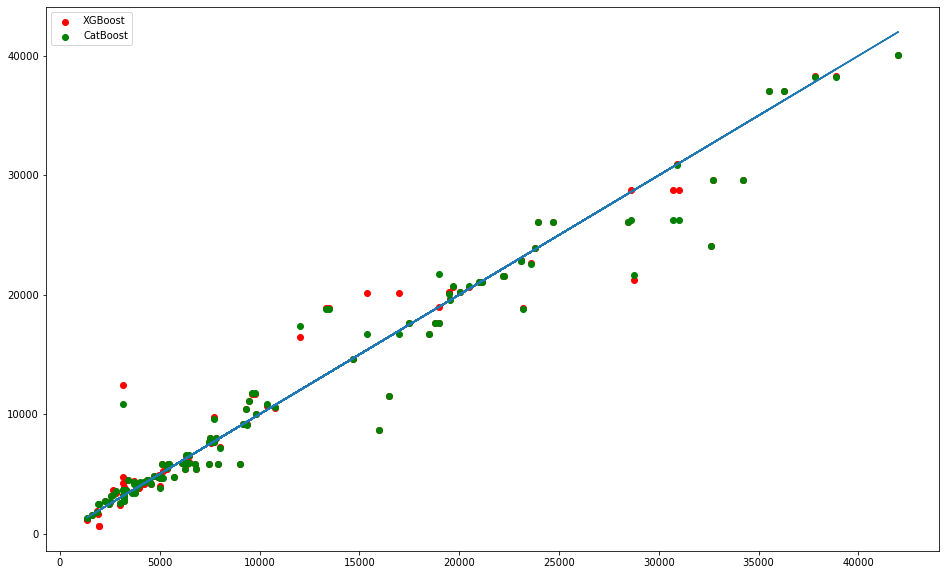

In [58]:
##  Visualize the predictions made by 2 different models. 
## CatBoostRegressor looks to be slightly better than XGBoostRegressor

plt.figure(figsize=(16,10))
plt.plot(y_test,y_test)
plt.scatter(y_test,y_pred1,color='r', label = 'XGBoost')
plt.scatter(y_test,y_pred2,color='g',label='CatBoost')
plt.legend()
plt.show()

In [59]:
pairs = {}
for k,v in zip(df1.Brand.unique(),np.arange(9)):
    pairs[k]=v
    
pairs

{'Apple': 0,
 'General Mobile': 1,
 'Huawei': 2,
 'Oppo': 3,
 'POCO': 4,
 'realme': 5,
 'Reeder': 6,
 'Samsung': 7,
 'TCL': 8}

**In the cell below, the code requires you to enter the desired features of a smartphone and predicts price for those product features.**

In [60]:
Brand = input('Brand :').lower().title().strip()
Brand = pairs[Brand]
if Brand =='apple':
    OS = 1
else:
    OS = 0
    
Cpu = input('Cpu:')
RAM = input('RAM:')
Storage= input('Storage:')
Cam= input('Camera Resolution:')
Scr= input('Screen Size:')


feat=np.array([Brand,Cpu,RAM,Storage,OS,Cam,Scr])
pricex = model2.predict(feat)                            ## input cell for user to define desired features. The model makes prediction

print(f'The Price of the product : {pricex}')

Brand :apple
Cpu:3.2
RAM:8
Storage:64
Camera Resolution:16
Screen Size:6.25
The Price of the product : 12351.889497727287
